# Hopefully the FINAL notebook I'll need

In [117]:
import pandas as pd
import glob
import os
import numpy as np

In [118]:
def merge_csv_files(folder_path, output_file="merged.csv"):
    csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df.columns = [col.strip() for col in df.columns]
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(output_file, index=False)

# Use correct relative path for CICIDS2017 folder
merge_csv_files("../CICIDS2017", "merged.csv")

need to get this part to only include the top 50 features:

In [119]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

# ----------------------------
# SETTINGS
# ----------------------------
file_path = "merged.csv"
fraction = 0.48     # % of data to sample overall (keeps earliest fraction, preserves timeline)
seq_length = 10     # default LSTM sequence length (adjust as needed)

# ----------------------------
# 1) Load in chunks (preserve order)
# ----------------------------
chunks = []
chunk_size = 10_000
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # Strip whitespace from column names
    chunk.columns = chunk.columns.str.strip()

    # Downcast numerics
    for col in chunk.select_dtypes(include=['int', 'float']).columns:
        if pd.api.types.is_integer_dtype(chunk[col]):
            chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
        else:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')

    # Replace NaN/Inf inside chunk
    chunk = chunk.replace([np.inf, -np.inf], np.nan).fillna(0)

    chunks.append(chunk)

data = pd.concat(chunks, ignore_index=True)
del chunks  # free memory

# ----------------------------
# 2) Label to binary
# ----------------------------
if "Label" not in data.columns:
    raise KeyError("Expected a 'Label' column.")

data["Label"] = data["Label"].apply(
    lambda x: 0 if str(x).strip().upper() == "BENIGN" else 1
).astype(np.int32)

# ----------------------------
# 3) Optional overall fraction (preserves order)
# ----------------------------
if fraction < 1.0:
    n_sample = max(1, int(len(data) * fraction))
    data = data.iloc[:n_sample].copy()

# ----------------------------
# 4) Time-aware benign downsampling (keeps chronology)
# ----------------------------
def time_aware_downsample_benign(df, label_col="Label", max_benign_ratio=0.55):
    keep_mask = np.zeros(len(df), dtype=bool)
    benign_kept = 0
    attack_kept = 0

    label = df[label_col].to_numpy()

    for i in range(len(df)):
        if label[i] == 1:
            keep_mask[i] = True
            attack_kept += 1
        else:
            proposed_benign = benign_kept + 1
            proposed_total  = proposed_benign + attack_kept
            if proposed_total == 0:
                keep_mask[i] = True
                benign_kept += 1
            else:
                if (proposed_benign / proposed_total) <= max_benign_ratio:
                    keep_mask[i] = True
                    benign_kept += 1

    kept = df.loc[keep_mask]
    return kept

def time_aware_stratified_downsample(df, label_col="Label", max_benign_ratio=0.55, 
                                   time_window_size=1000):
    """
    Downsample benign samples while maintaining both chronology AND 
    better class balance across time windows.
    """
    keep_mask = np.zeros(len(df), dtype=bool)
    label = df[label_col].to_numpy()
    
    # Process in time windows to ensure stratification across time
    for window_start in range(0, len(df), time_window_size):
        window_end = min(window_start + time_window_size, len(df))
        window_labels = label[window_start:window_end]
        
        # Count attacks in this window
        attack_count = np.sum(window_labels == 1)
        benign_count = np.sum(window_labels == 0)
        
        # Calculate how many benign samples to keep in this window
        if attack_count == 0:
            # If no attacks, keep some benign samples
            benign_to_keep = min(benign_count, int(time_window_size * (1 - max_benign_ratio)))
        else:
            # Calculate based on desired ratio
            total_attacks_kept = attack_count
            max_benign_to_keep = int(total_attacks_kept * max_benign_ratio / (1 - max_benign_ratio))
            benign_to_keep = min(benign_count, max_benign_to_keep)
        
        # Keep all attacks in this window
        attack_indices = np.where(window_labels == 1)[0] + window_start
        keep_mask[attack_indices] = True
        
        # Keep chronologically first benign samples in this window
        benign_indices = np.where(window_labels == 0)[0] + window_start
        if len(benign_indices) > 0 and benign_to_keep > 0:
            keep_benign = benign_indices[:benign_to_keep]  # Keep first ones chronologically
            keep_mask[keep_benign] = True
    
    return df.loc[keep_mask].reset_index(drop=True)

# Apply chronology-safe downsampling
data = time_aware_stratified_downsample(data, label_col="Label", max_benign_ratio=0.55)

# ----------------------------
# 5) Cap extreme values (exclude the label)
# ----------------------------
numeric_cols = [c for c in data.select_dtypes(include=[np.number]).columns if c != "Label"]
for col in numeric_cols:
    cap_value = data[col].quantile(0.999)
    data[col] = np.clip(data[col], a_min=None, a_max=cap_value)

# ----------------------------
# 6) Feature selection: keep only TOP 50 features
# ----------------------------
X = data.drop(columns=["Label"])
y = data["Label"]

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X, y)

importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(50).index.tolist()

print("\nTop 50 selected features:")
print(top_features)

data = data[top_features + ["Label"]]

# ----------------------------
# 7) Dtypes for ML (features float32, label int32)
# ----------------------------
for col in top_features:
    data[col] = data[col].astype(np.float32)
data["Label"] = data["Label"].astype(np.int32)

# ----------------------------
# Save final reduced dataset
# ----------------------------
data.to_csv("new_merged.csv", index=False)

# ----------------------------
# Final assignment for downstream code
# ----------------------------
datadf = data.copy()
ftnames = [c.strip() for c in datadf.columns if c.strip() != "Label"]

print(f"\nFinal shape: {datadf.shape}")
print(f"Number of features: {len(ftnames)}")
print("First few feature names:", ftnames[:10])
print("Label distribution:\n", datadf['Label'].value_counts())

# ======================================================================
# Chronology-safe sequence utilities (NO shuffling, NO stratify anywhere)
# ======================================================================

def create_sequences(X, y, sequence_length=10, label_strategy='last'):
    """
    Create overlapping sequences without breaking chronology.
    label_strategy: 'last' | 'majority' | 'any_attack'
    """
    if len(X) < sequence_length:
        sequence_length = len(X)
        print(f"[create_sequences] Adjusted sequence_length to {sequence_length}")

    X_sequences, y_sequences = [], []
    for i in range(len(X) - sequence_length + 1):
        X_seq = X[i:i+sequence_length]
        y_seq = y[i:i+sequence_length]
        X_sequences.append(X_seq)

        if label_strategy == 'last':
            y_sequences.append(y_seq[-1])
        elif label_strategy == 'majority':
            y_sequences.append(1 if np.sum(y_seq) > (len(y_seq) // 2) else 0)
        elif label_strategy == 'any_attack':
            y_sequences.append(1 if (y_seq == 1).any() else 0)
        else:
            raise ValueError(f"Unknown label_strategy: {label_strategy}")

    X_sequences = np.asarray(X_sequences, dtype=np.float32)
    y_sequences = np.asarray(y_sequences, dtype=np.float32)

    return X_sequences, y_sequences

def chrono_split_train_val_test(df, label_col="Label", train_ratio=0.7, val_ratio=0.15):
    """
    Chronological split on rows (NO shuffle). Test gets the tail.
    """
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    n_test = n - n_train - n_val

    train_df = df.iloc[:n_train]
    val_df   = df.iloc[n_train:n_train+n_val]
    test_df  = df.iloc[n_train+n_val:]

    def xy(d):
        X = d.drop(columns=[label_col]).to_numpy(dtype=np.float32)
        y = d[label_col].to_numpy(dtype=np.int32)
        return X, y

    return xy(train_df), xy(val_df), xy(test_df)

def build_chrono_sequences(df, label_col="Label", sequence_length=10, label_strategy='last'):
    """
    Split chronologically on raw rows, then build sequences inside each split so
    no sequence crosses split boundaries.
    """
    (X_tr, y_tr), (X_va, y_va), (X_te, y_te) = chrono_split_train_val_test(df, label_col=label_col)

    X_train_seq, y_train_seq = create_sequences(X_tr, y_tr, sequence_length, label_strategy)
    X_val_seq,   y_val_seq   = create_sequences(X_va, y_va, sequence_length, label_strategy)
    X_test_seq,  y_test_seq  = create_sequences(X_te, y_te, sequence_length, label_strategy)

    # Quick sanity print
    def _dist(y):
        c = Counter(y.astype(int).tolist())
        total = len(y)
        if total == 0:
            return {}
        return {k: f"{v} ({v/total:.2%})" for k, v in sorted(c.items())}

    print("\n=== Chronological split (sequence-level) ===")
    print(f"Train seq: {X_train_seq.shape}, dist: { _dist(y_train_seq) }")
    print(f"Val   seq: {X_val_seq.shape}, dist: { _dist(y_val_seq) }")
    print(f"Test  seq: {X_test_seq.shape}, dist: { _dist(y_test_seq) }")

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq

from sklearn.model_selection import TimeSeriesSplit

def build_chrono_kfold_sequences(df, label_col="Label", sequence_length=10, 
                                label_strategy='last', n_splits=5):
    """
    K-fold cross-validation that maintains chronological order.
    Each fold uses progressively more past data for training.
    """
    # Convert to numpy arrays first
    X_full = df.drop(columns=[label_col]).to_numpy(dtype=np.float32)
    y_full = df[label_col].to_numpy(dtype=np.int32)
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_data = []
    
    print(f"\n=== Chronological K-Fold ({n_splits} splits) ===")
    
    for fold_idx, (train_idx, val_idx) in enumerate(tscv.split(X_full)):
        # Maintain chronological order (TimeSeriesSplit already does this)
        X_train_fold = X_full[train_idx]
        y_train_fold = y_full[train_idx]
        X_val_fold = X_full[val_idx]
        y_val_fold = y_full[val_idx]
        
        # Create sequences within each fold (no cross-contamination)
        X_train_seq, y_train_seq = create_sequences(X_train_fold, y_train_fold, 
                                                   sequence_length, label_strategy)
        X_val_seq, y_val_seq = create_sequences(X_val_fold, y_val_fold, 
                                               sequence_length, label_strategy)
        
        # Distribution info
        def _dist(y):
            c = Counter(y.astype(int).tolist())
            total = len(y)
            if total == 0:
                return {}
            return {k: f"{v} ({v/total:.2%})" for k, v in sorted(c.items())}
        
        print(f"Fold {fold_idx+1}: Train={X_train_seq.shape}, Val={X_val_seq.shape}")
        print(f"  Train dist: {_dist(y_train_seq)}")
        print(f"  Val dist: {_dist(y_val_seq)}")
        
        fold_data.append({
            'fold': fold_idx,
            'X_train': X_train_seq,
            'y_train': y_train_seq,
            'X_val': X_val_seq,
            'y_val': y_val_seq
        })
    
    return fold_data


Top 50 selected features:
['Fwd Packet Length Max', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes', 'Fwd Packet Length Mean', 'Init_Win_bytes_forward', 'Total Length of Fwd Packets', 'Average Packet Size', 'Init_Win_bytes_backward', 'PSH Flag Count', 'Min Packet Length', 'Bwd Packet Length Min', 'Packet Length Std', 'Max Packet Length', 'Packet Length Mean', 'Destination Port', 'Packet Length Variance', 'Bwd Packet Length Max', 'Bwd Packet Length Mean', 'Fwd Header Length.1', 'Fwd Header Length', 'Total Fwd Packets', 'Bwd Header Length', 'Subflow Fwd Packets', 'Fwd IAT Max', 'Flow Bytes/s', 'Fwd IAT Total', 'act_data_pkt_fwd', 'Fwd Packet Length Std', 'ACK Flag Count', 'Bwd Packet Length Std', 'Avg Bwd Segment Size', 'Flow IAT Max', 'Flow Duration', 'Total Length of Bwd Packets', 'URG Flag Count', 'Bwd Packets/s', 'Flow IAT Std', 'Subflow Bwd Bytes', 'Fwd IAT Std', 'Fwd IAT Mean', 'Fwd Packet Length Min', 'Fwd IAT Min', 'Flow IAT Mean', 'Flow Packets/s', 'Subflow Bwd Packets', 'Total Bac

In [120]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    classification_report, accuracy_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import optuna
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [121]:
def print_data_info(X, y, stage_name):
    """Print comprehensive data information"""
    print(f"\n=== {stage_name} Data Info ===")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Labels shape: {y.shape}")
    print(f"Feature data type: {X.dtype}")
    print(f"Label data type: {y.dtype}")
    
    # Check for NaN/inf values
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
    print(f"NaN values in features: {nan_count}")
    print(f"Inf values in features: {inf_count}")
    
    # Basic statistics
    print(f"Feature matrix - Min: {X.min():.4f}, Max: {X.max():.4f}, Mean: {X.mean():.4f}")
    
    # Label distribution
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Label distribution:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(y)) * 100
        print(f"  Class {int(label)}: {count} samples ({percentage:.2f}%)")
    
    # Sample some labels
    print(f"First 20 labels: {y[:20]}")
    print(f"Last 20 labels: {y[-20:]}")

def validate_data_splits(X_train, y_train, X_val, y_val, X_test, y_test):
    """Validate that data splits preserve class distribution"""
    print("\n=== Data Split Validation ===")
    
    # Check shapes
    print(f"Original total samples: {len(X_train) + len(X_val) + len(X_test)}")
    print(f"Train: {X_train.shape[0]} ({X_train.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    print(f"Val: {X_val.shape[0]} ({X_val.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    print(f"Test: {X_test.shape[0]} ({X_test.shape[0]/(len(X_train) + len(X_val) + len(X_test))*100:.1f}%)")
    
    # Check class distributions
    datasets = [("Train", y_train), ("Val", y_val), ("Test", y_test)]
    
    print("\nClass distributions across splits:")
    for name, y_split in datasets:
        unique_labels, counts = np.unique(y_split, return_counts=True)
        print(f"{name}:")
        for label, count in zip(unique_labels, counts):
            percentage = (count / len(y_split)) * 100
            print(f"  Class {int(label)}: {count} samples ({percentage:.2f}%)")
    
    # Check for data leakage indicators
    print(f"\nFeature statistics consistency check:")
    print(f"Train mean: {X_train.mean():.6f}")
    print(f"Val mean: {X_val.mean():.6f}")
    print(f"Test mean: {X_test.mean():.6f}")

def check_preprocessing_integrity(X_before, y_before, X_after, y_after, stage_name):
    """Check if preprocessing preserved data integrity"""
    print(f"\n=== {stage_name} Preprocessing Integrity Check ===")
    
    # Shape consistency
    assert X_before.shape[0] == X_after.shape[0], f"Sample count mismatch: {X_before.shape[0]} vs {X_after.shape[0]}"
    assert len(y_before) == len(y_after), f"Label count mismatch: {len(y_before)} vs {len(y_after)}"
    print("✓ Sample counts preserved")
    
    # Label consistency
    assert np.array_equal(y_before, y_after), "Labels were modified during preprocessing!"
    print("✓ Labels preserved")
    
    # Feature scaling check
    if stage_name == "Scaling":
        print(f"Before scaling - Min: {X_before.min():.4f}, Max: {X_before.max():.4f}")
        print(f"After scaling - Min: {X_after.min():.4f}, Max: {X_after.max():.4f}")
        print(f"After scaling - Mean: {X_after.mean():.6f}, Std: {X_after.std():.6f}")


In [122]:
class BaselineEvaluator:
    def __init__(self):
        self.models = {}
        self.results = {}
    
    def add_dummy_classifier(self, X_train, y_train):
        """Add majority class predictor"""
        print("Adding Majority Class Predictor...")
        self.models['majority_class'] = DummyClassifier(strategy='most_frequent', random_state=42)
        self.models['majority_class'].fit(X_train, y_train)
    
    def add_logistic_regression(self, X_train, y_train):
        """Add logistic regression baseline"""
        print("Adding Logistic Regression...")
        self.models['logistic_regression'] = LogisticRegression(
            random_state=42, 
            max_iter=1000,
            class_weight='balanced'
        )
        self.models['logistic_regression'].fit(X_train, y_train)
    
    def add_random_forest(self, X_train, y_train):
        """Add random forest baseline"""
        print("Adding Random Forest...")
        self.models['random_forest'] = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        )
        self.models['random_forest'].fit(X_train, y_train)
    
    def add_knn(self, X_train, y_train):
        """Add KNN baseline"""
        print("Adding KNN...")
        # Use smaller sample for KNN if dataset is too large
        if len(X_train) > 10000:
            print(f"Using subset of {min(5000, len(X_train))} samples for KNN training...")
            indices = np.random.choice(len(X_train), min(5000, len(X_train)), replace=False)
            X_train_knn = X_train[indices]
            y_train_knn = y_train[indices]
        else:
            X_train_knn = X_train
            y_train_knn = y_train
            
        self.models['knn'] = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
        self.models['knn'].fit(X_train_knn, y_train_knn)
    
    def evaluate_all(self, X_test, y_test, model_name_prefix="Baseline"):
        """Evaluate all baseline models"""
        print(f"\n=== {model_name_prefix} Model Evaluation ===")
        
        for name, model in self.models.items():
            print(f"\nEvaluating {name.replace('_', ' ').title()}...")
            
            # Predictions
            try:
                y_pred = model.predict(X_test)
                y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else y_pred
            except Exception as e:
                print(f"Error with {name}: {e}")
                continue
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            # AUC calculation
            try:
                if len(np.unique(y_test)) > 1:
                    auc = roc_auc_score(y_test, y_prob)
                    pr_auc = average_precision_score(y_test, y_prob)
                else:
                    auc = pr_auc = 0.5
            except:
                auc = pr_auc = 0.5
            
            # Store results
            self.results[name] = {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc,
                'pr_auc': pr_auc,
                'y_pred': y_pred,
                'y_prob': y_prob
            }
            
            # Print results
            print(f"  Accuracy:  {accuracy:.4f}")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall:    {recall:.4f}")
            print(f"  F1 Score:  {f1:.4f}")
            print(f"  AUC:       {auc:.4f}")
            print(f"  PR-AUC:    {pr_auc:.4f}")
    
    def plot_confusion_matrices(self, y_test):
        """Plot confusion matrices for all models with robust error handling"""
        n_models = len(self.results)  # Use results, not models
        if n_models == 0:
            print("No model results available for confusion matrix plotting")
            return
        
        print(f"Plotting confusion matrices for {n_models} models...")
        
        # Try the subplot approach first
        try:
            cols = min(3, n_models)
            rows = (n_models + cols - 1) // cols
            
            fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
            
            # Convert to 2D array for consistent indexing
            if n_models == 1:
                axes = np.array([[axes]])
            elif rows == 1:
                axes = axes.reshape(1, -1)
            elif cols == 1:
                axes = axes.reshape(-1, 1)
            
            plot_idx = 0
            for name, results in self.results.items():
                try:
                    row = plot_idx // cols
                    col = plot_idx % cols
                    
                    ax = axes[row, col]
                    
                    cm = confusion_matrix(y_test, results['y_pred'])
                    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
                    ax.set_title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}')
                    ax.set_xlabel('Predicted')
                    ax.set_ylabel('Actual')
                    
                    plot_idx += 1
                    
                except Exception as e:
                    print(f"Error plotting confusion matrix for {name}: {e}")
                    plot_idx += 1
                    continue
            
            # Hide empty subplots
            for idx in range(n_models, rows * cols):
                try:
                    row = idx // cols
                    col = idx % cols
                    axes[row, col].axis('off')
                except:
                    continue
            
            plt.tight_layout()
            plt.show()
            print("✅ Confusion matrices plotted successfully")
            
        except Exception as e:
            print(f"Subplot approach failed: {e}")
            print("Falling back to individual plots...")
            
            # Fallback: individual plots
            try:
                for name, results in self.results.items():
                    try:
                        plt.figure(figsize=(6, 4))
                        cm = confusion_matrix(y_test, results['y_pred'])
                        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                        plt.title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}')
                        plt.xlabel('Predicted')
                        plt.ylabel('Actual')
                        plt.tight_layout()
                        plt.show()
                        print(f"✅ Confusion matrix for {name} plotted")
                    except Exception as e2:
                        print(f"❌ Failed to plot confusion matrix for {name}: {e2}")
                        
            except Exception as e3:
                print(f"❌ All plotting approaches failed: {e3}")
                print("Skipping confusion matrix plots...")
    
    def get_results_summary(self):
        """Get summary of all baseline results"""
        if not self.results:
            print("No results available for summary")
            return pd.DataFrame()
            
        summary_data = []
        for name, results in self.results.items():
            summary_data.append({
                'Model': name.replace('_', ' ').title(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1': results['f1'],
                'AUC': results['auc'],
                'PR-AUC': results['pr_auc']
            })
        
        return pd.DataFrame(summary_data).round(4)
    
    # Replace your plot_confusion_matrices method with this simple version
    def plot_confusion_matrices(self, y_test):
        """Plot confusion matrices for all models - Simple version"""
        if not self.results:
            print("No results available for plotting")
            return
        
        print(f"Plotting confusion matrices for {len(self.results)} models...")
        
        # Use simple individual plots to avoid matplotlib axes issues
        for name, results in self.results.items():
            try:
                print(f"Plotting confusion matrix for {name}...")
                
                # Create a new figure for each model
                plt.figure(figsize=(6, 5))
                
                # Calculate confusion matrix
                cm = confusion_matrix(y_test, results['y_pred'])
                
                # Use matplotlib directly instead of seaborn to avoid axes issues
                plt.imshow(cm, interpolation='nearest', cmap='Blues')
                plt.colorbar()
                
                # Add text annotations
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        plt.text(j, i, str(cm[i, j]), 
                                ha='center', va='center', 
                                color='white' if cm[i, j] > cm.max() / 2 else 'black',
                                fontsize=14, fontweight='bold')
                
                # Labels and title
                plt.title(f'{name.replace("_", " ").title()}\nF1: {results["f1"]:.3f}, AUC: {results["auc"]:.3f}', 
                        fontsize=12, pad=20)
                plt.xlabel('Predicted Label', fontsize=11)
                plt.ylabel('True Label', fontsize=11)
                
                # Set tick labels
                tick_labels = ['Benign', 'Attack']
                plt.xticks(range(len(tick_labels)), tick_labels)
                plt.yticks(range(len(tick_labels)), tick_labels)
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error plotting confusion matrix for {name}: {e}")
                # Still try to show basic metrics
                try:
                    cm = confusion_matrix(y_test, results['y_pred'])
                    print(f"  Confusion Matrix for {name}:")
                    print(f"    {cm}")
                except:
                    print(f"  Could not generate any visualization for {name}")
        
        print("✅ Confusion matrix plotting completed")
    
    def get_results_summary(self):
        """Get summary of all baseline results"""
        if not self.results:
            return pd.DataFrame()
            
        summary_data = []
        for name, results in self.results.items():
            summary_data.append({
                'Model': name.replace('_', ' ').title(),
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1': results['f1'],
                'AUC': results['auc'],
                'PR-AUC': results['pr_auc']
            })
        
        return pd.DataFrame(summary_data).round(4)

In [123]:
SEQ_LENGTH = 30

In [124]:
from collections import Counter
import numpy as np

# ==========================================================
# Chronology-safe prepare_lstm_sequences_fixed
# ==========================================================
def prepare_lstm_sequences_fixed(X, y, sequence_length=SEQ_LENGTH, label_strategy='majority'):
    """
    Convert tabular data to sequences for LSTM training with better label handling.
    Chronology preserved (NO shuffling).
    """
    print(f"Creating sequences of length {sequence_length} with {label_strategy} labeling...")

    if len(X) < sequence_length:
        sequence_length = len(X)
        print(f"Adjusted sequence length to {sequence_length} due to limited data")

    X_sequences = []
    y_sequences = []

    for i in range(len(X) - sequence_length + 1):
        X_seq = X[i:i + sequence_length]
        y_seq = y[i:i + sequence_length]
        X_sequences.append(X_seq)

        if label_strategy == 'last':
            y_sequences.append(y_seq[-1])
        elif label_strategy == 'majority':
            y_sequences.append(1 if np.sum(y_seq) > len(y_seq) // 2 else 0)
        elif label_strategy == 'any_attack':
            y_sequences.append(1 if np.any(y_seq == 1) else 0)

    X_sequences = np.array(X_sequences, dtype=np.float32)
    y_sequences = np.array(y_sequences, dtype=np.int32)

    print(f"Created {len(X_sequences)} sequences")
    print(f"Sequence shape: {X_sequences.shape}")

    # Distribution debug
    original_dist = Counter(y)
    sequence_dist = Counter(y_sequences)
    print(f"Original distribution: {dict(original_dist)}")
    print(f"Sequence distribution: {dict(sequence_dist)}")

    return X_sequences, y_sequences


# ==========================================================
# Chronology-safe create_stratified_sequences
# (renamed internally but kept external name)
# ==========================================================
def create_stratified_sequences(X, y, sequence_length=SEQ_LENGTH, test_size=0.4, val_split=0.5, random_state=42):
    """
    Chronology-safe split of sequences (replaces stratified split).
    """
    print("Creating chronology-safe sequences (no stratify)...")

    # Step 1: build sequences
    X_seq, y_seq = prepare_lstm_sequences_fixed(X, y, sequence_length, label_strategy='majority')

    # Step 2: split chronologically
    n_total = len(X_seq)
    n_test = int(n_total * test_size)
    n_val = int((n_total - n_test) * val_split)

    train_end = n_total - n_test - n_val
    val_end   = n_total - n_test

    X_train_seq, y_train_seq = X_seq[:train_end], y_seq[:train_end]
    X_val_seq,   y_val_seq   = X_seq[train_end:val_end], y_seq[train_end:val_end]
    X_test_seq,  y_test_seq  = X_seq[val_end:], y_seq[val_end:]

    validate_sequence_splits(X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq)

    return X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq


# ==========================================================
# validate_sequence_splits (unchanged, still works)
# ==========================================================
def validate_sequence_splits(X_train, y_train, X_val, y_val, X_test, y_test):
    """Validate sequence splits maintain reasonable class distribution"""
    print("\n=== Sequence Split Validation ===")
    splits = [("Train", y_train), ("Val", y_val), ("Test", y_test)]

    for name, y_split in splits:
        if len(y_split) > 0:
            attack_ratio = np.sum(y_split) / len(y_split)
            benign_count = len(y_split) - np.sum(y_split)
            attack_count = np.sum(y_split)
            print(f"{name}: {benign_count} benign, {attack_count} attack (ratio: {attack_ratio:.3f})")
        else:
            print(f"{name}: Empty split!")


# ==========================================================
# get_balanced_class_weights (no change needed)
# ==========================================================
def get_balanced_class_weights(y_train):
    """Calculate balanced class weights with safety checks"""
    class_counts = Counter(y_train)
    print(f"Training class counts: {dict(class_counts)}")

    if len(class_counts) < 2:
        print("⚠️  WARNING: Only one class in training data!")
        return {0: 1.0, 1: 1.0}

    total_samples = len(y_train)
    n_classes = len(class_counts)
    class_weights = {cls: total_samples / (n_classes * count) for cls, count in class_counts.items()}

    print(f"Calculated class weights: {class_weights}")
    return class_weights


In [125]:
class AdvancedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3, 
                 use_attention=True, bidirectional=True):
        super().__init__()
        
        self.use_attention = use_attention
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        print(f"Initializing AdvancedLSTM:")
        print(f"  Input dim: {input_dim}")
        print(f"  Hidden dim: {hidden_dim}")
        print(f"  Num layers: {num_layers}")
        print(f"  Dropout: {dropout}")
        print(f"  Attention: {use_attention}")
        print(f"  Bidirectional: {bidirectional}")
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        lstm_output_dim = hidden_dim * 2 if bidirectional else hidden_dim
        
        # Attention mechanism
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=lstm_output_dim,
                num_heads=4,
                dropout=dropout,
                batch_first=True
            )
        
        # Classification head with residual connection
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"  Total parameters: {total_params:,}")
        print(f"  Trainable parameters: {trainable_params:,}")
        
    def forward(self, x, return_features=False):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        
        if self.use_attention:
            # Apply attention to all time steps
            attended_out, attention_weights = self.attention(lstm_out, lstm_out, lstm_out)
            # Use mean of attended outputs
            features = attended_out.mean(dim=1)
        else:
            # Use last time step
            features = lstm_out[:, -1, :]

        if return_features:
            return features  # Return the hidden layer values (pre-classifier)
        
        # Classification
        logits = self.classifier(features)
        
        return logits.squeeze(-1)

In [126]:
def train_advanced_lstm_enhanced(X_train, y_train, X_val, y_val, params, model, epochs=30, min_delta=1e-4):
    """
    Enhanced training with better overfitting prevention and chronology preservation.
    """
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    import numpy as np
    from collections import Counter
    from sklearn.metrics import roc_auc_score, f1_score

    # Ensure float32 for GPU efficiency
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)

    # Prepare datasets with NO shuffling (chronology preserved)
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=False,  # CRITICAL: NO shuffling to preserve chronology
        pin_memory=True,
        num_workers=2,
        persistent_workers=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=params['batch_size'],
        shuffle=False,  # CRITICAL: NO shuffling
        pin_memory=True,
        num_workers=2,
        persistent_workers=True
    )

    # Optimizer with stronger weight decay if specified
    weight_decay = params.get('l2_reg', 1e-5)
    if params.get('optimizer') == 'adamw':
        optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=params['lr'], 
            weight_decay=weight_decay
        )
    else:
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=params['lr'],
            weight_decay=weight_decay
        )

    # Conservative learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max',  # Monitor validation F1 (maximize)
        factor=0.5,  # Reduce LR by half
        patience=params.get('reduce_lr_patience', 8),
        verbose=True,
        min_lr=params.get('min_lr', 1e-6)
    )

    # Loss function with class balancing
    device = next(model.parameters()).device
    class_counts = Counter(y_train)
    
    if len(class_counts) > 1:
        pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
        print(f"Using pos_weight: {pos_weight.item():.3f} (Benign/Attack ratio)")
    else:
        pos_weight = torch.tensor([1.0], device=device)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Training monitoring
    train_losses, val_aucs, val_f1s = [], [], []
    best_val_f1 = 0
    best_model_state = None
    patience = params.get('early_stopping_patience', 17)
    patience_counter = 0
    
    # Overfitting detection variables
    consecutive_loss_drops = 0
    loss_drop_threshold = 0.9  # If loss drops by 90% in one epoch, flag it

    print(f"Training for max {epochs} epochs with early stopping (patience={patience})")
    print(f"Batch size: {params['batch_size']}, Learning rate: {params['lr']}")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)

            # Primary loss
            loss = criterion(outputs, batch_y)
            
            # L2 regularization (if not using weight_decay in optimizer)
            if params.get('l2_reg', 0) > 0 and params.get('optimizer') != 'adamw':
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss += params['l2_reg'] * l2_norm

            loss.backward()
            
            # Gradient clipping
            clip_value = params.get('gradient_clip', 1.0)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
            
            optimizer.step()
            epoch_loss += loss.item()
            batch_count += 1

        avg_train_loss = epoch_loss / batch_count
        train_losses.append(avg_train_loss)

        # Overfitting detection: Check for suspiciously fast loss drops
        if epoch > 0:
            loss_drop_ratio = (train_losses[-2] - avg_train_loss) / train_losses[-2]
            if loss_drop_ratio > loss_drop_threshold:
                consecutive_loss_drops += 1
                print(f"WARNING: Large loss drop detected: {loss_drop_ratio:.1%}")
                if consecutive_loss_drops >= 2:
                    print("ALERT: Multiple consecutive large loss drops - possible overfitting!")
            else:
                consecutive_loss_drops = 0

        # Validation phase
        model.eval()
        val_probs, val_targets = [], []

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                outputs = model(batch_X)
                
                # Check for NaN outputs
                if torch.isnan(outputs).any():
                    print(f"WARNING: NaN detected in outputs at epoch {epoch+1}")
                    continue
                
                val_probs.extend(torch.sigmoid(outputs).cpu().numpy())
                val_targets.extend(batch_y.numpy())

        if len(val_probs) == 0:
            print(f"ERROR: No valid validation predictions at epoch {epoch+1}")
            break

        val_probs = np.array(val_probs)
        val_targets = np.array(val_targets)

        # Calculate validation metrics
        if len(np.unique(val_targets)) > 1:
            val_auc = roc_auc_score(val_targets, val_probs)
        else:
            val_auc = 0.5
            print(f"WARNING: Only one class in validation set at epoch {epoch+1}")

        # Find best F1 threshold
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = []
        for t in thresholds:
            try:
                f1 = f1_score(val_targets, (val_probs >= t).astype(int), zero_division=0)
                f1_scores.append(f1)
            except:
                f1_scores.append(0.0)
        
        best_f1 = max(f1_scores) if f1_scores else 0.0
        val_aucs.append(val_auc)
        val_f1s.append(best_f1)

        # Early stopping logic
        if best_f1 > best_val_f1 + min_delta:
            best_val_f1 = best_f1
            best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1

        # Step the scheduler (monitoring validation F1)
        scheduler.step(best_f1)

        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
            break

        # Progress reporting
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1:2d}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val F1: {best_f1:.4f} | "
              f"Val AUC: {val_auc:.4f} | "
              f"LR: {current_lr:.2e}")

        # Additional overfitting warnings
        if epoch >= 5 and best_f1 > 0.995:
            print("WARNING: Suspiciously high validation F1 (>99.5%) - check for data leakage!")
        
        if epoch >= 3 and avg_train_loss < 0.01:
            print("WARNING: Very low training loss - possible overfitting")

    # Load best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"Loaded best model with validation F1: {best_val_f1:.4f}")
    else:
        print("WARNING: No improvement found, using final epoch model")
    
    # Save the best model to disk
    torch.save(model.state_dict(), "best_lstm_model.pth")
    print("✅ Best model saved to best_lstm_model.pth")

    return model, train_losses, val_aucs, val_f1s


In [127]:
def advanced_objective(trial, X_train_seq, y_train_seq):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'num_layers': trial.suggest_int('num_layers', 2, 4),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 5e-5, 5e-3, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'use_attention': trial.suggest_categorical('use_attention', [True, False]),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False]),
        'optimizer': trial.suggest_categorical('optimizer', ['adam', 'adamw']),
        'l2_reg': trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True),
    }
    
    if params['optimizer'] == 'adamw':
        params['weight_decay'] = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    
    try:
        # Use cross-validation for more robust evaluation
        kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        cv_scores = []
        
        for train_idx, val_idx in kf.split(X_train_seq, y_train_seq):
            X_cv_train, X_cv_val = X_train_seq[train_idx], X_train_seq[val_idx]
            y_cv_train, y_cv_val = y_train_seq[train_idx], y_train_seq[val_idx]

            # 🔹 Build a fresh model for each CV split
            input_dim = X_train_seq.shape[2]
            num_classes = len(np.unique(y_train_seq))
            
            model = AdvancedLSTM(
                input_dim=input_dim,
                hidden_dim=params['hidden_dim'],
                num_layers=params['num_layers'],
                dropout=params['dropout'],
                use_attention=params['use_attention'],
                bidirectional=params['bidirectional']
            ).to(device)


            _, _, _, val_f1s = train_advanced_lstm_enhanced(
                X_cv_train, y_cv_train,
                X_cv_val, y_cv_val,
                params,
                model,
                epochs=15
            )
            
            cv_scores.append(max(val_f1s))
        
        return np.mean(cv_scores)
    
    except Exception as e:
        print(f"Trial failed: {e}")
        return 0.0


In [128]:
def analyze_feature_importance(model, X_sample, feature_names):
    """Analyze which features are most important for predictions"""
    # Store original model state
    original_training_state = model.training
    
    # Set model to training mode for gradient computation
    model.train()
    
    try:
        # Use gradient-based feature importance
        X_tensor = torch.FloatTensor(X_sample[:100]).to(device)  # Use subset for speed
        X_tensor.requires_grad_(True)
        
        outputs = model(X_tensor)
        
        # Calculate gradients
        outputs.sum().backward()
        gradients = X_tensor.grad.abs().mean(dim=[0, 1]).cpu().numpy()
        
        # Create feature importance DataFrame
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': gradients
        }).sort_values('importance', ascending=False)
        
        return importance_df
    
    except Exception as e:
        print(f"Error in feature importance analysis: {e}")
        # Return dummy DataFrame in case of error
        return pd.DataFrame({
            'feature': feature_names,
            'importance': np.zeros(len(feature_names))
        })
    
    finally:
        # Restore original model state
        model.train(original_training_state)

def plot_advanced_results(train_losses, val_aucs, val_f1s, test_results):
    """Create comprehensive result plots"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Training history
    axes[0, 0].plot(train_losses)
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].plot(val_aucs, label='AUC', color='blue')
    axes[0, 1].plot(val_f1s, label='F1', color='red')
    axes[0, 1].set_title('Validation Metrics')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # ROC and PR curves
    fpr, tpr, _ = roc_curve(test_results['y_true'], test_results['y_prob'])
    axes[0, 2].plot(fpr, tpr, label=f'AUC = {test_results["auc"]:.4f}')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 2].set_title('ROC Curve')
    axes[0, 2].set_xlabel('False Positive Rate')
    axes[0, 2].set_ylabel('True Positive Rate')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    precision, recall, _ = precision_recall_curve(test_results['y_true'], test_results['y_prob'])
    axes[1, 0].plot(recall, precision, label=f'PR-AUC = {test_results["pr_auc"]:.4f}')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Confusion matrix
    cm = confusion_matrix(test_results['y_true'], test_results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1, 1], cmap='Blues')
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    
    # Threshold analysis
    thresholds = np.linspace(0.1, 0.9, 100)
    f1_scores = []
    for t in thresholds:
        try:
            f1 = f1_score(test_results['y_true'], (test_results['y_prob'] >= t).astype(int))
            f1_scores.append(f1)
        except:
            f1_scores.append(0.0)
    
    axes[1, 2].plot(thresholds, f1_scores)
    axes[1, 2].axvline(x=test_results['best_threshold'], color='red', linestyle='--')
    axes[1, 2].set_title('F1 Score vs Threshold')
    axes[1, 2].set_xlabel('Threshold')
    axes[1, 2].set_ylabel('F1 Score')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(baseline_results_df, lstm_results):
    """Plot comparison between baseline models and LSTM"""
    # Add LSTM results to comparison
    lstm_row = pd.DataFrame({
        'Model': ['Advanced LSTM'],
        'Accuracy': [lstm_results.get('accuracy', 0)],
        'Precision': [lstm_results['precision']],
        'Recall': [lstm_results['recall']],
        'F1': [lstm_results['f1']],
        'AUC': [lstm_results['auc']],
        'PR-AUC': [lstm_results['pr_auc']]
    })
    
    comparison_df = pd.concat([baseline_results_df, lstm_row], ignore_index=True)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'PR-AUC']
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum', 'lightpink']
    
    for i, (metric, color) in enumerate(zip(metrics, colors)):
        row, col = i // 3, i % 3
        ax = axes[row, col]
        
        bars = ax.bar(comparison_df['Model'], comparison_df[metric], color=color, alpha=0.7)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Highlight best model
        best_idx = comparison_df[metric].idxmax()
        bars[best_idx].set_color('red')
        bars[best_idx].set_alpha(0.9)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [129]:
import tqdm
from tqdm import tqdm  

In [130]:
# ==============================
# STEP 1: Data Loading and Initial Sanity Checks
# ==============================
print("\n=== STEP 1: Data Loading and Initial Validation ===")    
try:
    # Load data
    print("Loading CICIDS2017 dataset...")
    df, feature_names = datadf, ftnames  # pre-loaded globals
        
    # Extract features and labels
    if 'Label' in df.columns:
        X = df.drop('Label', axis=1).values
        y = df['Label'].values
    elif 'label' in df.columns:
        X = df.drop('label', axis=1).values
        y = df['label'].values
    else:
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
        
    # Convert labels to binary - FIXED VERSION
    if y.dtype == 'object' or len(np.unique(y)) > 2:
        print("Converting labels to binary classification...")
        benign_labels = ['BENIGN', 'Normal', 'normal', 'benign', 0, '0']
        
        unique_labels, counts = np.unique(y, return_counts=True)
        print("Original label distribution:")
        for label, count in zip(unique_labels, counts):
            print(f"  {label}: {count} samples")
            
        # FIXED: Proper binary conversion using boolean indexing
        y_binary = np.ones(len(y), dtype=int)  # Start with all as attack (1)
        
        # Create boolean mask for benign samples
        benign_mask = np.isin(y, benign_labels)
        y_binary[benign_mask] = 0  # Set benign samples to 0
        
        print(f"Benign samples found: {np.sum(benign_mask)} out of {len(y)}")
        print(f"Attack samples: {np.sum(~benign_mask)} out of {len(y)}")
        
        y = y_binary
        print("Converted to binary classification (0=Benign, 1=Attack)")
    else:
        print("Labels already appear to be binary")
        
    # Ensure numeric features
    if X.dtype == 'object':
        print("Converting features to numeric...")
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        for col in range(X.shape[1]):
            if df.iloc[:, col].dtype == 'object':
                X[:, col] = le.fit_transform(X[:, col].astype(str))
        X = X.astype(float)
        
    # Data quality checks
    nan_count = np.isnan(X).sum()
    inf_count = np.isinf(X).sum()
        
    if nan_count > 0:
        print(f"Replacing {nan_count} NaN values with median...")
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        X = imputer.fit_transform(X)
            
    if inf_count > 0:
        print(f"Replacing {inf_count} infinite values...")
        X = np.nan_to_num(X, nan=0.0, posinf=1e10, neginf=-1e10)
        
    print(f"Dataset loaded successfully!")
    print(f"Total samples: {len(X)}")
    print(f"Total features: {X.shape[1]}")
        
    # FIXED: More robust class distribution check
    unique_labels, counts = np.unique(y, return_counts=True)
    print(f"Final class distribution after conversion:")
    for label, count in zip(unique_labels, counts):
        class_name = "Benign" if label == 0 else "Attack"
        print(f"  {class_name} (label={label}): {count} samples")
    
    # Calculate attack ratio safely
    if len(counts) >= 2:
        benign_count = counts[unique_labels == 0][0] if 0 in unique_labels else 0
        attack_count = counts[unique_labels == 1][0] if 1 in unique_labels else 0
        attack_ratio = attack_count / len(y)
    else:
        # Only one class present
        if unique_labels[0] == 0:
            benign_count, attack_count = counts[0], 0
        else:
            benign_count, attack_count = 0, counts[0]
        attack_ratio = attack_count / len(y)
    
    print(f"Attack ratio: {attack_ratio:.3f}")
        
    if attack_ratio < 0.01:
        print(f"⚠️  SEVERE CLASS IMBALANCE: Only {attack_ratio:.3%} attacks!")
    elif attack_ratio > 0.99:
        print(f"⚠️  SEVERE CLASS IMBALANCE: Only {(1-attack_ratio):.3%} benign!")
        
    # 🔍 EXTRA: Feature-label correlation check
    try:
        corrs = [np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])]
        max_corr = np.nanmax(np.abs(corrs))
        if max_corr > 0.95:
            print(f"🚨 POTENTIAL DATA LEAKAGE: Feature correlates with label at {max_corr:.3f}")
    except Exception as e:
        print(f"Could not compute feature-label correlation: {e}")
        
except Exception as e:
    print(f"Error loading data: {e}")


=== STEP 1: Data Loading and Initial Validation ===
Loading CICIDS2017 dataset...
Labels already appear to be binary
Dataset loaded successfully!
Total samples: 712286
Total features: 50
Final class distribution after conversion:
  Benign (label=0): 423343 samples
  Attack (label=1): 288943 samples
Attack ratio: 0.406


In [131]:
# ==============================
# STEP 2: CHUNK-BASED BALANCED TEMPORAL SPLITTING
# ==============================
print("\n=== STEP 2: Chunk-Based Balanced Temporal Splitting ===")
print("🍭 'Candy Store' Approach: Distribute temporal chunks to achieve balance")

# ==============================
# CHUNK ANALYSIS & PREPARATION
# ==============================
print("\n🔍 ANALYZING TEMPORAL CHUNKS...")

# Create temporal chunks
n_chunks = 20  # More chunks = finer control
chunk_size = len(y) // n_chunks
chunks_info = []

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, len(y))
    
    chunk_X = X[start_idx:end_idx]
    chunk_y = y[start_idx:end_idx]
    
    # Analyze chunk composition
    unique_vals, counts = np.unique(chunk_y, return_counts=True)
    total_samples = len(chunk_y)
    benign_count = counts[unique_vals == 0][0] if 0 in unique_vals else 0
    attack_count = counts[unique_vals == 1][0] if 1 in unique_vals else 0
    
    attack_ratio = attack_count / total_samples
    
    chunk_info = {
        'id': i,
        'start_pct': start_idx / len(y) * 100,
        'end_pct': end_idx / len(y) * 100,
        'X': chunk_X,
        'y': chunk_y,
        'total_samples': total_samples,
        'benign_count': benign_count,
        'attack_count': attack_count,
        'attack_ratio': attack_ratio,
        'chunk_type': 'attack_heavy' if attack_ratio > 0.6 else 'benign_heavy' if attack_ratio < 0.4 else 'mixed'
    }
    chunks_info.append(chunk_info)
    
    print(f"Chunk {i+1:2d} ({chunk_info['start_pct']:3.0f}%-{chunk_info['end_pct']:3.0f}%): "
          f"A={attack_count:5d} B={benign_count:5d} | Ratio={attack_ratio:.3f} | {chunk_info['chunk_type']}")

# Categorize chunks
attack_heavy_chunks = [c for c in chunks_info if c['chunk_type'] == 'attack_heavy']
benign_heavy_chunks = [c for c in chunks_info if c['chunk_type'] == 'benign_heavy']
mixed_chunks = [c for c in chunks_info if c['chunk_type'] == 'mixed']

print(f"\nChunk categories:")
print(f"  Attack-heavy: {len(attack_heavy_chunks)} chunks")
print(f"  Benign-heavy: {len(benign_heavy_chunks)} chunks") 
print(f"  Mixed: {len(mixed_chunks)} chunks")

# ==============================
# SMART CHUNK ALLOCATION
# ==============================
print(f"\n🎯 ALLOCATING CHUNKS TO SPLITS...")

def allocate_chunks_for_balance(chunks_info, target_attack_ratio=0.5, train_ratio=0.6, val_ratio=0.2):
    """
    Allocate chunks to splits to achieve target balance
    """
    total_chunks = len(chunks_info)
    target_train_chunks = int(total_chunks * train_ratio)
    target_val_chunks = int(total_chunks * val_ratio) 
    target_test_chunks = total_chunks - target_train_chunks - target_val_chunks
    
    print(f"Target allocation: Train={target_train_chunks}, Val={target_val_chunks}, Test={target_test_chunks}")
    
    # Strategy: Distribute chunk types across splits to balance attack ratios
    train_chunks = []
    val_chunks = []
    test_chunks = []
    
    # Start with mixed chunks (easiest to balance)
    mixed_per_split = len(mixed_chunks) // 3
    train_chunks.extend(mixed_chunks[:mixed_per_split])
    val_chunks.extend(mixed_chunks[mixed_per_split:2*mixed_per_split])
    test_chunks.extend(mixed_chunks[2*mixed_per_split:])
    
    # Distribute attack-heavy and benign-heavy chunks
    remaining_attack_heavy = attack_heavy_chunks.copy()
    remaining_benign_heavy = benign_heavy_chunks.copy()
    
    # Fill remaining slots, balancing attack ratios
    splits = [
        ('train', train_chunks, target_train_chunks),
        ('val', val_chunks, target_val_chunks), 
        ('test', test_chunks, target_test_chunks)
    ]
    
    for split_name, split_chunks, target_size in splits:
        while len(split_chunks) < target_size:
            # Calculate current attack ratio for this split
            current_attacks = sum(c['attack_count'] for c in split_chunks)
            current_total = sum(c['total_samples'] for c in split_chunks)
            current_ratio = current_attacks / current_total if current_total > 0 else 0
            
            # Decide what type of chunk to add
            if current_ratio < target_attack_ratio - 0.05 and remaining_attack_heavy:
                # Need more attacks
                chunk = remaining_attack_heavy.pop(0)
                split_chunks.append(chunk)
                print(f"  {split_name}: Added attack-heavy chunk {chunk['id']} (ratio={chunk['attack_ratio']:.3f})")
            elif current_ratio > target_attack_ratio + 0.05 and remaining_benign_heavy:
                # Need more benign
                chunk = remaining_benign_heavy.pop(0)
                split_chunks.append(chunk)
                print(f"  {split_name}: Added benign-heavy chunk {chunk['id']} (ratio={chunk['attack_ratio']:.3f})")
            elif remaining_attack_heavy:
                chunk = remaining_attack_heavy.pop(0)
                split_chunks.append(chunk)
            elif remaining_benign_heavy:
                chunk = remaining_benign_heavy.pop(0)
                split_chunks.append(chunk)
            else:
                break
    
    # Add any remaining chunks to the splits
    all_remaining = remaining_attack_heavy + remaining_benign_heavy
    for i, chunk in enumerate(all_remaining):
        target_split = i % 3
        if target_split == 0:
            train_chunks.append(chunk)
        elif target_split == 1:
            val_chunks.append(chunk)
        else:
            test_chunks.append(chunk)
    
    return train_chunks, val_chunks, test_chunks

# Allocate chunks
train_chunk_list, val_chunk_list, test_chunk_list = allocate_chunks_for_balance(chunks_info)

# ==============================
# COMBINE CHUNKS INTO SPLITS
# ==============================
print(f"\n🔧 COMBINING CHUNKS INTO FINAL SPLITS...")

def combine_chunks(chunk_list, split_name):
    """Combine chunks while maintaining temporal order within each chunk"""
    if not chunk_list:
        print(f"⚠️  {split_name}: No chunks allocated!")
        return np.array([]), np.array([])
    
    # Sort chunks by temporal order (chunk ID)
    chunk_list.sort(key=lambda x: x['id'])
    
    X_combined = []
    y_combined = []
    
    total_samples = 0
    total_attacks = 0
    total_benign = 0
    
    chunk_ids = []
    for chunk in chunk_list:
        X_combined.append(chunk['X'])
        y_combined.append(chunk['y'])
        total_samples += chunk['total_samples']
        total_attacks += chunk['attack_count']
        total_benign += chunk['benign_count']
        chunk_ids.append(chunk['id'])
    
    X_final = np.vstack(X_combined) if X_combined else np.array([]).reshape(0, X.shape[1])
    y_final = np.hstack(y_combined) if y_combined else np.array([])
    
    attack_ratio = total_attacks / total_samples if total_samples > 0 else 0
    
    print(f"{split_name}:")
    print(f"  Chunks: {chunk_ids}")
    print(f"  Samples: {total_samples:,} | Benign: {total_benign:,} ({total_benign/total_samples:.1%}) | Attack: {total_attacks:,} ({attack_ratio:.1%})")
    
    return X_final, y_final

# Create final splits
X_train, y_train = combine_chunks(train_chunk_list, "TRAIN")
X_val, y_val = combine_chunks(val_chunk_list, "VAL")
X_test, y_test = combine_chunks(test_chunk_list, "TEST")

# ==============================
# FINAL VALIDATION & REPORTING
# ==============================
print(f"\n{'='*60}")
print(f"🎯 FINAL CHUNK-BASED RESULTS")
print(f"{'='*60}")

total_retained = len(X_train) + len(X_val) + len(X_test)
retention_rate = total_retained / len(X) * 100

print(f"Dataset size: {len(X):,} → {total_retained:,} ({retention_rate:.1f}% retained)")
print(f"Split sizes: Train={len(X_train):,} | Val={len(X_val):,} | Test={len(X_test):,}")

# Final balance check
print(f"\nFINAL CLASS DISTRIBUTIONS:")
for name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    if len(y_split) == 0:
        print(f"{name:5s}: 🚨 EMPTY SPLIT!")
        continue
        
    unique_vals, counts = np.unique(y_split, return_counts=True)
    total = len(y_split)
    
    if len(unique_vals) >= 2:
        benign_count = counts[unique_vals == 0][0] if 0 in unique_vals else 0
        attack_count = counts[unique_vals == 1][0] if 1 in unique_vals else 0
        
        benign_pct = benign_count / total
        attack_pct = attack_count / total
        minority_pct = min(benign_pct, attack_pct) * 100
        
        print(f"{name:5s}: Benign={benign_pct:.1%} | Attack={attack_pct:.1%} | Minority={minority_pct:.1f}%", end="")
        
        if minority_pct >= 25:  # More relaxed for test set
            print(" ✅ USABLE")
        else:
            print(f" ⚠️  STILL IMBALANCED")
    else:
        print(f"{name:5s}: 🚨 SINGLE CLASS ({unique_vals[0]}) - {counts[0]:,} samples!")

# Verify data integrity
if total_retained > 0:
    print(f"\n✅ Data integrity: {len(X):,} → {total_retained:,} samples")
    print(f"🍭 Temporal chunks successfully distributed!")
else:
    print(f"\n🚨 ERROR: No samples retained!")

print(f"\n🚀 Ready for training with chunk-balanced splits!")


=== STEP 2: Chunk-Based Balanced Temporal Splitting ===
🍭 'Candy Store' Approach: Distribute temporal chunks to achieve balance

🔍 ANALYZING TEMPORAL CHUNKS...
Chunk  1 (  0%-  5%): A=23517 B=12097 | Ratio=0.660 | attack_heavy
Chunk  2 (  5%- 10%): A=30459 B= 5155 | Ratio=0.855 | attack_heavy
Chunk  3 ( 10%- 15%): A=30752 B= 4862 | Ratio=0.863 | attack_heavy
Chunk  4 ( 15%- 20%): A=29505 B= 6109 | Ratio=0.828 | attack_heavy
Chunk  5 ( 20%- 25%): A=13801 B=21813 | Ratio=0.388 | benign_heavy
Chunk  6 ( 25%- 30%): A= 6100 B=29514 | Ratio=0.171 | benign_heavy
Chunk  7 ( 30%- 35%): A=35203 B=  411 | Ratio=0.988 | attack_heavy
Chunk  8 ( 35%- 40%): A=33931 B= 1683 | Ratio=0.953 | attack_heavy
Chunk  9 ( 40%- 45%): A=34857 B=  757 | Ratio=0.979 | attack_heavy
Chunk 10 ( 45%- 50%): A=30088 B= 5526 | Ratio=0.845 | attack_heavy
Chunk 11 ( 50%- 55%): A=18744 B=16870 | Ratio=0.526 | mixed
Chunk 12 ( 55%- 60%): A= 1966 B=33648 | Ratio=0.055 | benign_heavy
Chunk 13 ( 60%- 65%): A=    0 B=35614 | Ra

In [132]:
# ==============================
# STEP 3: Feature Scaling (Applied Chronologically)
# ==============================
print("\n=== STEP 3: Chronological Feature Scaling ===")
print("📊 Scaling based on training data only (no future information)")
    
    # Fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Transform only, no fitting
X_test_scaled = scaler.transform(X_test)  # Transform only, no fitting
    
    # DEBUG: Check for scaling issues
train_mean = np.mean(X_train_scaled, axis=0)
train_std = np.std(X_train_scaled, axis=0)
    
print(f"Training data after scaling - Mean range: [{train_mean.min():.6f}, {train_mean.max():.6f}]")
print(f"Training data after scaling - Std range: [{train_std.min():.6f}, {train_std.max():.6f}]")
    
    # Check for constant features (std = 0)
constant_features = np.sum(train_std < 1e-8)
if constant_features > 0:
    print(f"⚠️  {constant_features} constant features detected - these won't help learning")
    
print("✅ Feature scaling completed with temporal integrity")


=== STEP 3: Chronological Feature Scaling ===
📊 Scaling based on training data only (no future information)
Training data after scaling - Mean range: [-0.000000, 0.000000]
Training data after scaling - Std range: [1.000000, 1.000000]
✅ Feature scaling completed with temporal integrity


In [133]:
print("\n=== STEP 4: Baseline Model Evaluation ===")
    
baseline_eval = BaselineEvaluator()
print("Training baseline models...")
baseline_eval.add_dummy_classifier(X_train_scaled, y_train)
baseline_eval.add_logistic_regression(X_train_scaled, y_train)
baseline_eval.add_random_forest(X_train_scaled, y_train)
    
if len(X_train_scaled) <= 50000:
    baseline_eval.add_knn(X_train_scaled, y_train)
    
baseline_eval.evaluate_all(X_test_scaled, y_test, "Baseline")
baseline_results_df = baseline_eval.get_results_summary()
print("\n=== Baseline Results Summary ===")
print(baseline_results_df.to_string(index=False))


=== STEP 4: Baseline Model Evaluation ===
Training baseline models...
Adding Majority Class Predictor...
Adding Logistic Regression...
Adding Random Forest...

=== Baseline Model Evaluation ===

Evaluating Majority Class...
  Accuracy:  0.1317
  Precision: 0.1317
  Recall:    1.0000
  F1 Score:  0.2328
  AUC:       0.5000
  PR-AUC:    0.1317

Evaluating Logistic Regression...
  Accuracy:  0.9795
  Precision: 0.8737
  Recall:    0.9870
  F1 Score:  0.9269
  AUC:       0.9929
  PR-AUC:    0.9336

Evaluating Random Forest...
  Accuracy:  0.9907
  Precision: 0.9373
  Recall:    0.9958
  F1 Score:  0.9657
  AUC:       0.9982
  PR-AUC:    0.9795

=== Baseline Results Summary ===
              Model  Accuracy  Precision  Recall     F1    AUC  PR-AUC
     Majority Class    0.1317     0.1317  1.0000 0.2328 0.5000  0.1317
Logistic Regression    0.9795     0.8737  0.9870 0.9269 0.9929  0.9336
      Random Forest    0.9907     0.9373  0.9958 0.9657 0.9982  0.9795


In [134]:
window_length = 64

In [135]:
print("\n=== STEP 5: IMPROVED Chronological Sequence Creation ===")

def create_robust_sequences(X, y, seq_len, overlap_ratio=0.7, min_attack_ratio=0.01):
    """
    Create sequences with improved labeling and class balance validation
    """
    print(f"  Input: {len(X)} samples, sequence length: {seq_len}")
    
    if len(X) < seq_len:
        print(f"⚠️  Not enough samples for sequences (need {seq_len}, have {len(X)})")
        return np.array([]), np.array([])
    
    sequences = []
    labels = []
    
    # Use controlled overlap to prevent overfitting while maximizing data
    stride = max(1, int(seq_len * overlap_ratio))
    print(f"  Using stride: {stride} (overlap: {1-stride/seq_len:.1%})")
    
    for i in range(0, len(X) - seq_len + 1, stride):
        sequence = X[i:i + seq_len]
        sequence_labels = y[i:i + seq_len]
        
        # IMPROVED LABELING: Multiple strategies with validation
        attack_ratio = np.mean(sequence_labels)
        
        # Strategy: Attack if significant portion of sequence contains attacks
        sequence_label = 1 if attack_ratio >= min_attack_ratio else 0
        
        sequences.append(sequence)
        labels.append(sequence_label)
    
    sequences = np.array(sequences)
    labels = np.array(labels)
    
    print(f"  Created {len(sequences)} sequences")
    
    # Validate class distribution
    unique_seq, counts_seq = np.unique(labels, return_counts=True)
    print(f"    Class distribution: {dict(zip(unique_seq, counts_seq))}")
    
    if len(unique_seq) < 2:
        print(f"🚨 SINGLE CLASS DETECTED - Trying alternative labeling...")
        # Fallback: ANY attack in sequence
        labels = []
        for i in range(0, len(X) - seq_len + 1, stride):
            sequence_labels = y[i:i + seq_len]
            sequence_label = 1 if np.any(sequence_labels) else 0
            labels.append(sequence_label)
        
        labels = np.array(labels)
        unique_seq, counts_seq = np.unique(labels, return_counts=True)
        print(f"    Fallback distribution: {dict(zip(unique_seq, counts_seq))}")
    
    # Class balance check
    if len(unique_seq) > 1:
        minority_ratio = min(counts_seq) / len(labels)
        print(f"    Minority class ratio: {minority_ratio:.3f}")
        
        if minority_ratio < 0.05:
            print(f"    ⚠️ Severe class imbalance detected!")
    
    return sequences, labels

# Apply improved sequence creation
print("Creating robust sequences for all splits...")
sequence_length = window_length
X_train_seq, y_train_seq = create_robust_sequences(
    X_train_scaled, y_train, sequence_length, overlap_ratio=0.8
)

X_val_seq, y_val_seq = create_robust_sequences(
    X_val_scaled, y_val, sequence_length, overlap_ratio=0.5
)

X_test_seq, y_test_seq = create_robust_sequences(
    X_test_scaled, y_test, sequence_length, overlap_ratio=0.5
)

print(f"\nFinal sequence shapes:")
print(f"  Training: {X_train_seq.shape}")
print(f"  Validation: {X_val_seq.shape}")
print(f"  Test: {X_test_seq.shape}")


=== STEP 5: IMPROVED Chronological Sequence Creation ===
Creating robust sequences for all splits...
  Input: 427368 samples, sequence length: 64
  Using stride: 51 (overlap: 20.3%)
  Created 8379 sequences
    Class distribution: {np.int64(0): np.int64(3524), np.int64(1): np.int64(4855)}
    Minority class ratio: 0.421
  Input: 142456 samples, sequence length: 64
  Using stride: 32 (overlap: 50.0%)
  Created 4450 sequences
    Class distribution: {np.int64(0): np.int64(3469), np.int64(1): np.int64(981)}
    Minority class ratio: 0.220
  Input: 142456 samples, sequence length: 64
  Using stride: 32 (overlap: 50.0%)
  Created 4450 sequences
    Class distribution: {np.int64(0): np.int64(3746), np.int64(1): np.int64(704)}
    Minority class ratio: 0.158

Final sequence shapes:
  Training: (8379, 64, 50)
  Validation: (4450, 64, 50)
  Test: (4450, 64, 50)


In [ ]:
# ==============================
# STEP 6: ANTI-OVERFITTING PARAMETERS
# ==============================
print("\n=== STEP 6: Anti-Overfitting Configuration ===")

# Calculate class weights for imbalanced data
from collections import Counter
train_class_counts = Counter(y_train_seq)
print(f"Training class distribution: {dict(train_class_counts)}")

if len(train_class_counts) > 1:
    total_samples = sum(train_class_counts.values())
    class_weights = {
        cls: total_samples / (len(train_class_counts) * count) 
        for cls, count in train_class_counts.items()
    }
    pos_weight = class_weights.get(1, 1.0) / class_weights.get(0, 1.0)
    print(f"Calculated pos_weight: {pos_weight:.3f}")
else:
    pos_weight = 1.0
    print("⚠️ Single class detected, using default weight")

# CONSERVATIVE parameters to prevent overfitting
n_train = len(X_train_seq)
n_features = X_train_seq.shape[2]

best_params = {
    # Model architecture - keep simple
    'hidden_dim': min(64, max(32, n_features)),  # Scale with features but cap low
    'num_layers': 1,                             # Single layer to prevent overfitting
    'dropout': 0.5,                              # Strong dropout
    'use_attention': False,                       # Disable attention for simplicity
    'bidirectional': False,                       # Disable bidirectional
    
    # Training parameters
    'lr': 0.001,                                 # Conservative learning rate
    'batch_size': min(64, max(16, n_train // 20)), # Reasonable batch size
    'optimizer': 'adam',                         # Standard Adam
    'l2_reg': 1e-3,                             # Strong L2 regularization
    'gradient_clip': 1.0,                       # Gradient clipping
    
    # Early stopping
    'early_stopping_patience': 40,              # Increased patience
    'reduce_lr_patience': 7,                    # LR reduction patience
    'min_lr': 1e-6,                             # Minimum learning rate
    'min_delta': 1e-4,                          # Minimum improvement
    
    # Class imbalance handling
    'pos_weight': pos_weight,
    'focal_loss': False  # Keep simple for now
}

print(f"Conservative parameters: {best_params}")

# Model complexity check
model_params = best_params['hidden_dim'] * best_params['num_layers'] * n_features
complexity_ratio = model_params / n_train
print(f"Model complexity ratio: {complexity_ratio:.4f}")
if complexity_ratio > 0.1:
    print("⚠️ Still potentially complex - monitor for overfitting")


=== STEP 6: Anti-Overfitting Configuration ===
Training class distribution: {np.int64(0): 3524, np.int64(1): 4855}
Calculated pos_weight: 0.726
Conservative parameters: {'hidden_dim': 50, 'num_layers': 1, 'dropout': 0.5, 'use_attention': False, 'bidirectional': False, 'lr': 0.001, 'batch_size': 64, 'optimizer': 'adam', 'l2_reg': 0.001, 'gradient_clip': 1.0, 'early_stopping_patience': 20, 'reduce_lr_patience': 7, 'min_lr': 1e-06, 'min_delta': 0.0001, 'pos_weight': 0.725849639546859, 'focal_loss': False}
Model complexity ratio: 0.2984
⚠️ Still potentially complex - monitor for overfitting



=== STEP 7: Robust LSTM Training ===

=== Creating Anti-Overfitting Model ===
Initializing AdvancedLSTM:
  Input dim: 50
  Hidden dim: 50
  Num layers: 1
  Dropout: 0.5
  Attention: False
  Bidirectional: False
  Total parameters: 24,351
  Trainable parameters: 24,351
Model parameters: 24,351
Parameters per training sample: 2.91
Device: cuda
GPU test: cuda:0

🔍 Debugging tensor shapes...

=== TENSOR SHAPE DEBUGGING ===
Input X shape: torch.Size([5, 64, 50])
Input y shape: torch.Size([5])
Raw model output shape: torch.Size([5])
Raw model output: tensor([0.1291, 0.1327, 0.1385, 0.1387, 0.1380], device='cuda:0')
After squeeze(-1): torch.Size([5])
Target tensor final shape: torch.Size([5])
Shapes match: True

🚀 Starting robust training...
Starting training: 50 epochs, patience=20
Epoch  1 | Loss: T=0.6234 V=0.5868 | F1: T=0.6964 V=0.9242 | AUC: 0.9834
    ✅ New best F1: 0.9242


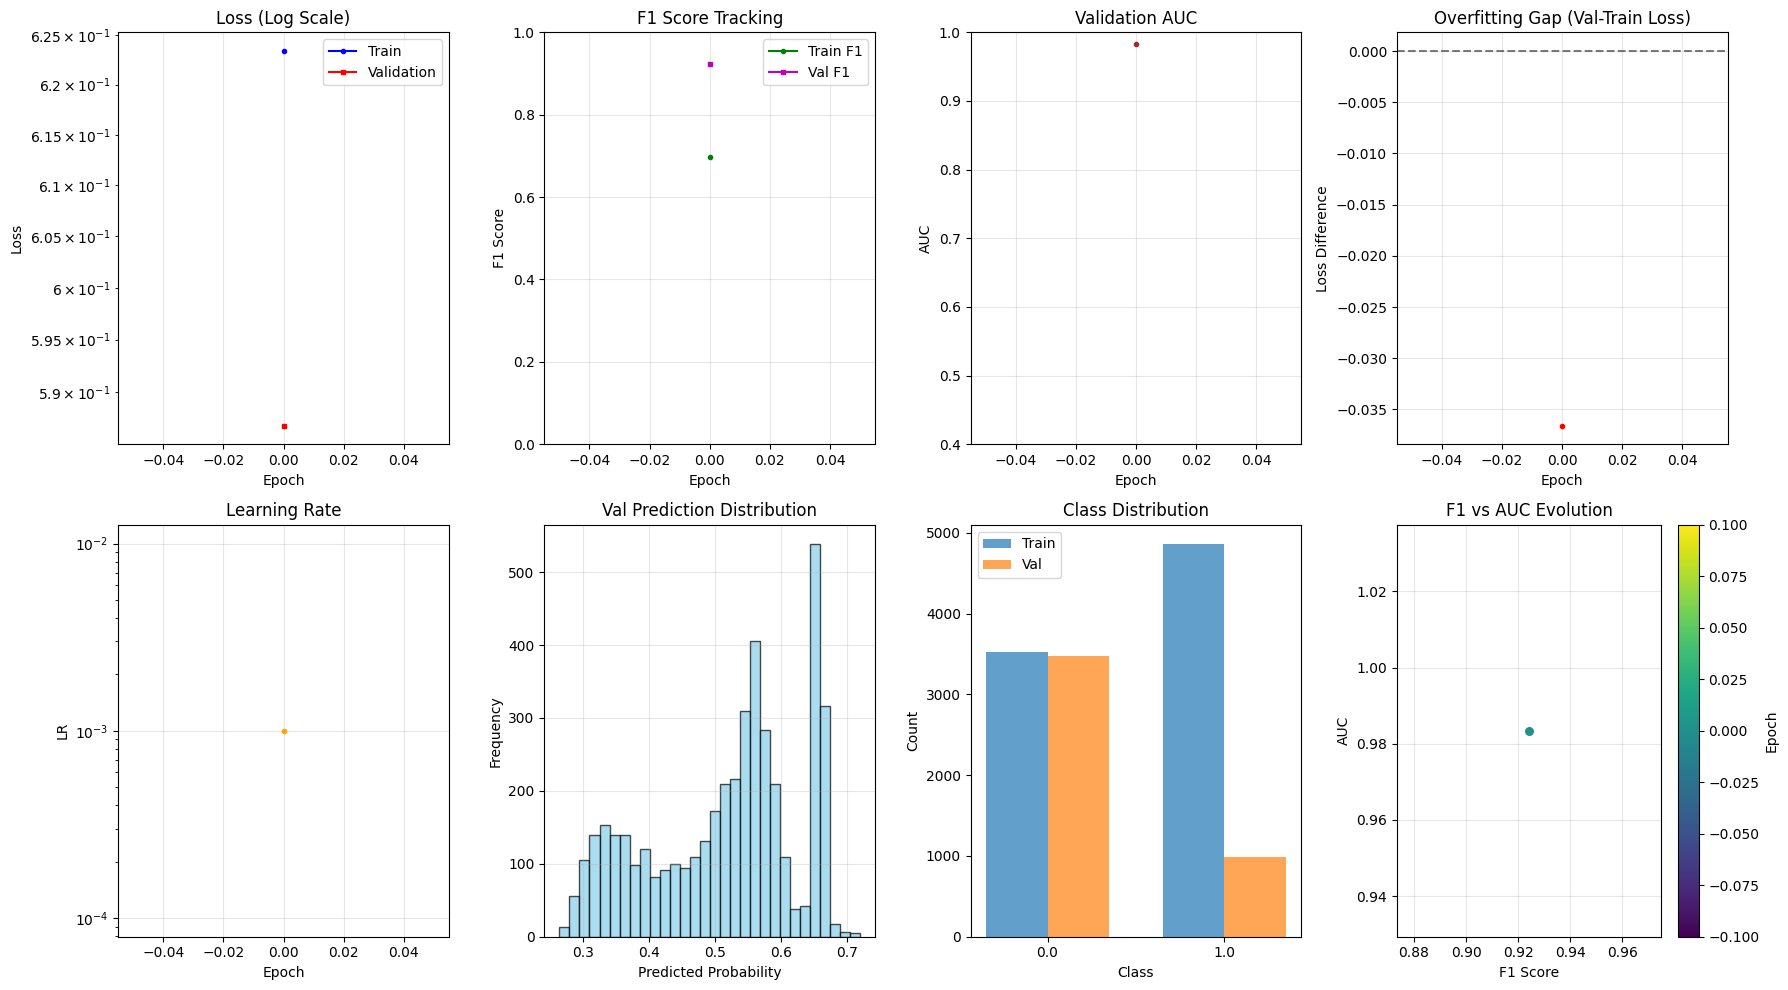

Epoch  2 | Loss: T=0.5186 V=0.2957 | F1: T=0.7706 V=0.9725 | AUC: 0.9845
    ✅ New best F1: 0.9725
Epoch  3 | Loss: T=0.3860 V=0.1368 | F1: T=0.8455 V=0.9733 | AUC: 0.9851
    ✅ New best F1: 0.9733


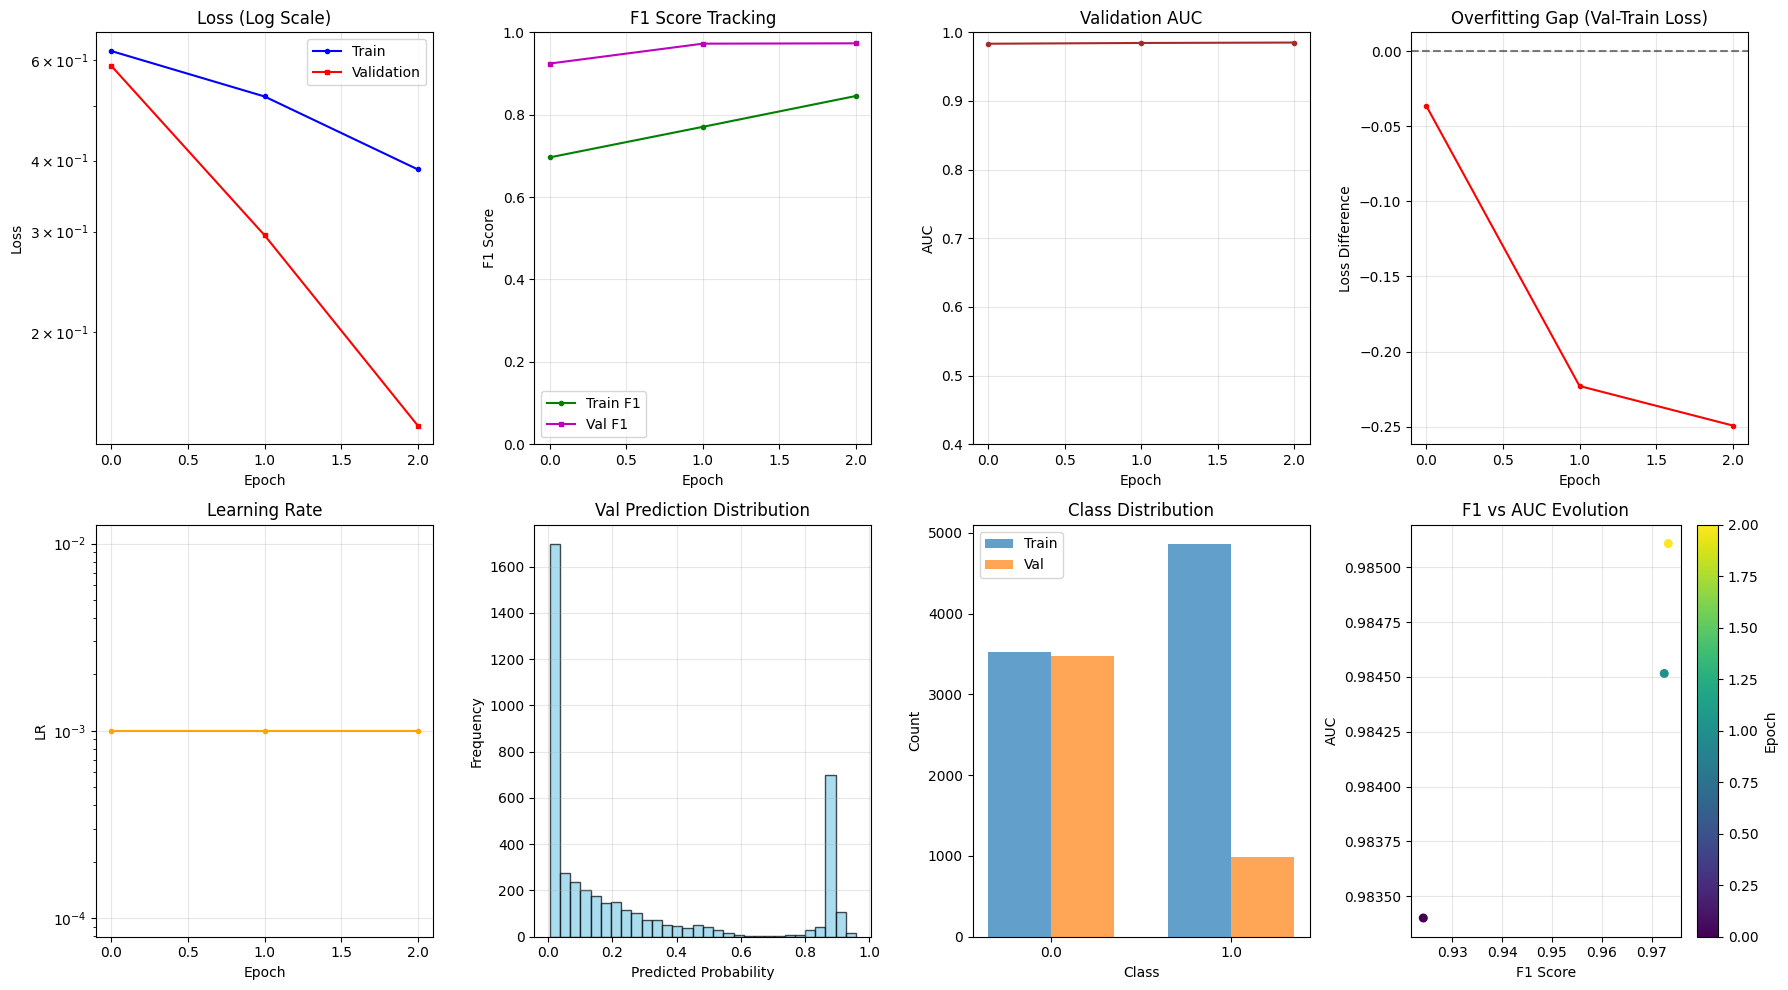

Epoch  4 | Loss: T=0.2776 V=0.1176 | F1: T=0.8992 V=0.9627 | AUC: 0.9828
Epoch  5 | Loss: T=0.2241 V=0.1129 | F1: T=0.9254 V=0.9695 | AUC: 0.9840
Epoch  6 | Loss: T=0.1908 V=0.0615 | F1: T=0.9375 V=0.9781 | AUC: 0.9860
    ✅ New best F1: 0.9781


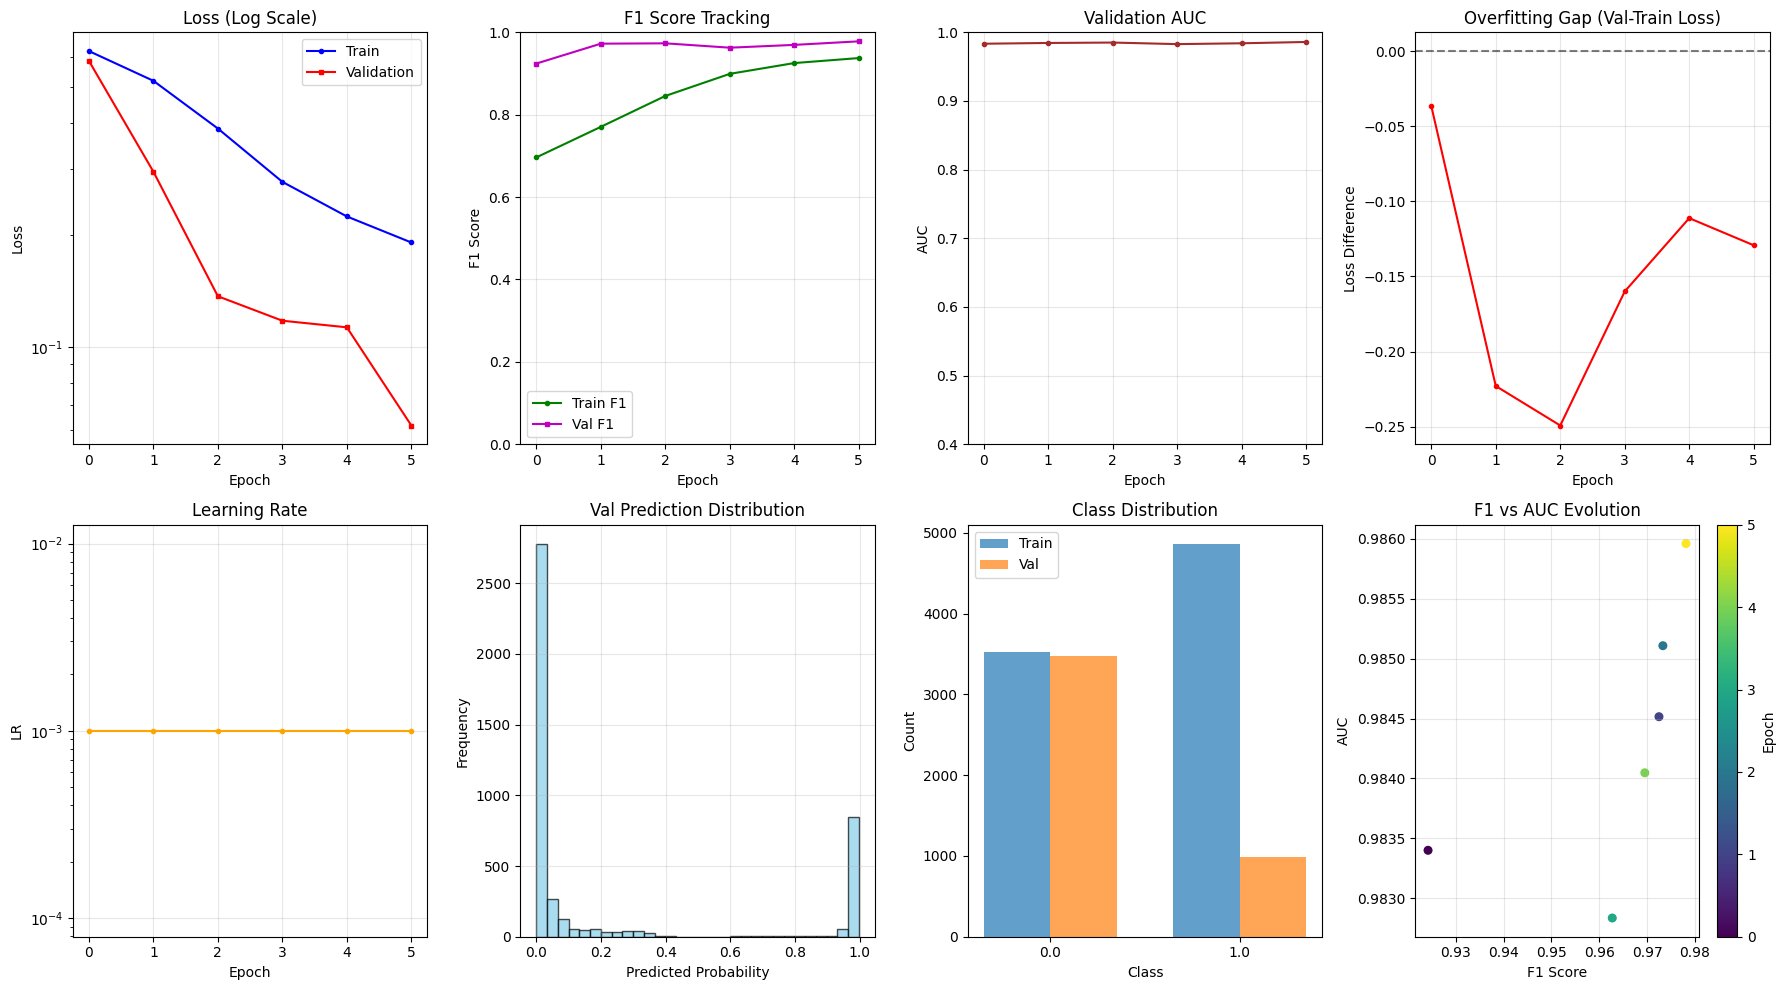

Epoch  7 | Loss: T=0.1625 V=0.0502 | F1: T=0.9481 V=0.9829 | AUC: 0.9875
    ✅ New best F1: 0.9829
Epoch  8 | Loss: T=0.1473 V=0.0443 | F1: T=0.9510 V=0.9850 | AUC: 0.9888
    ✅ New best F1: 0.9850
Epoch  9 | Loss: T=0.1419 V=0.0433 | F1: T=0.9546 V=0.9850 | AUC: 0.9883


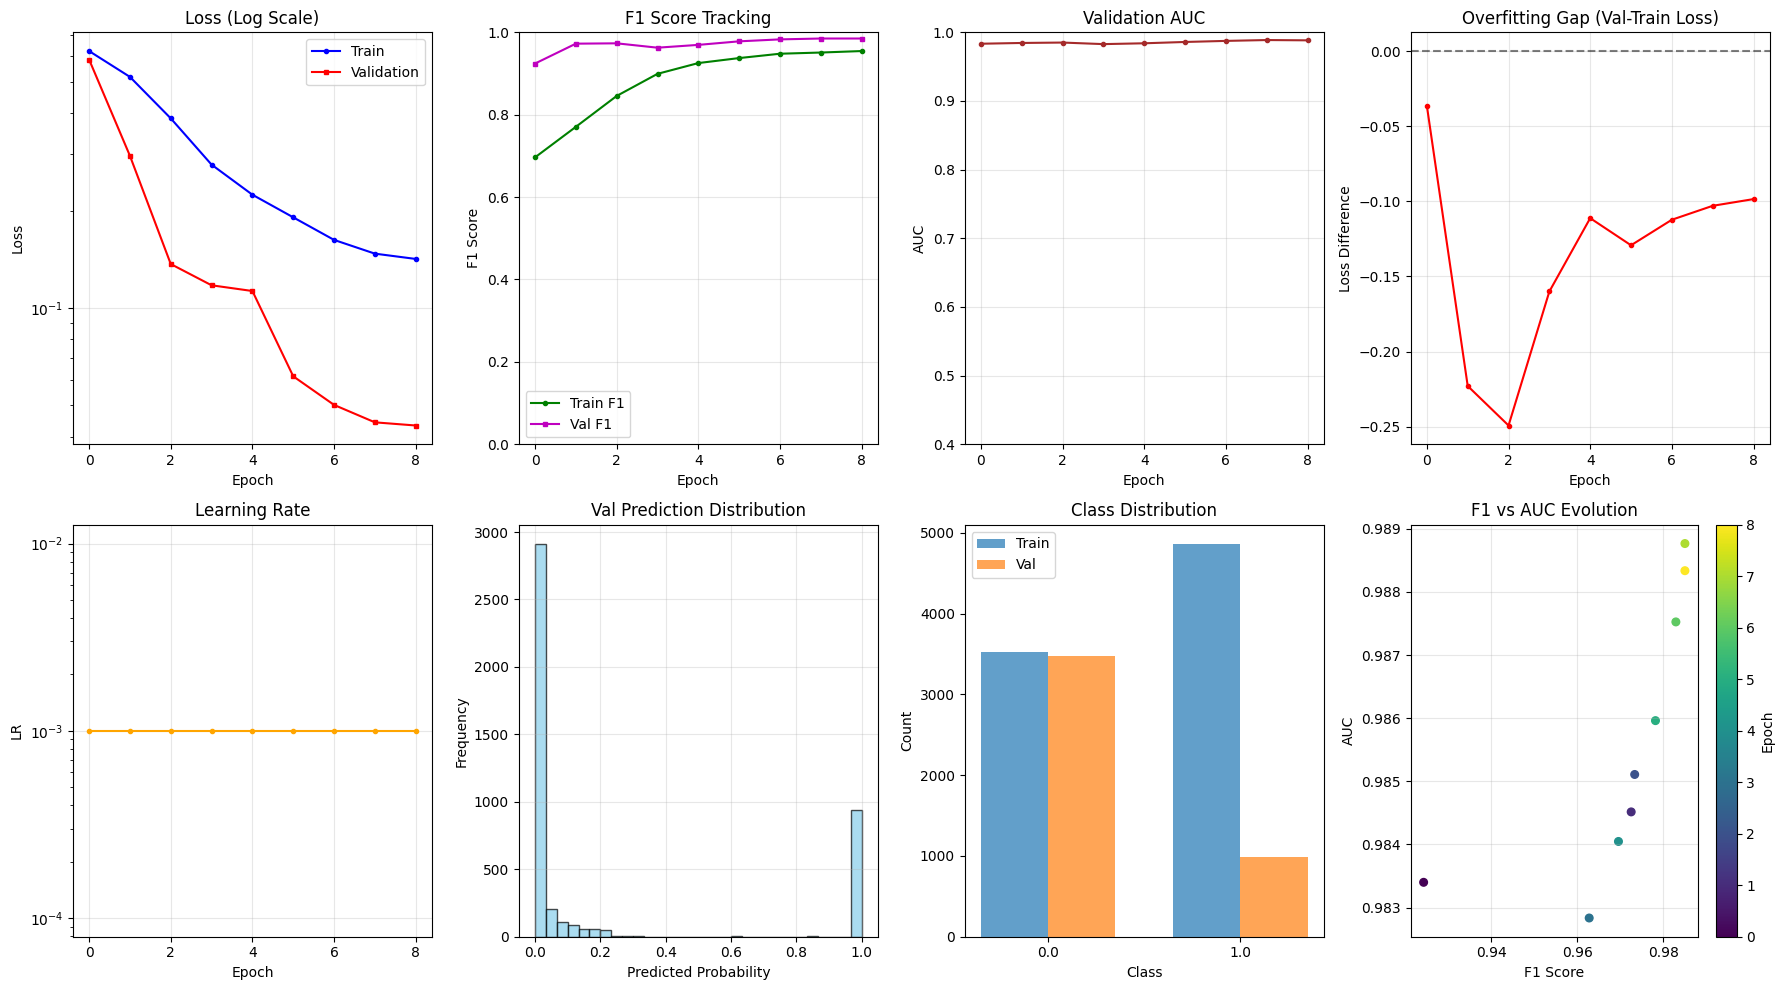

Epoch 10 | Loss: T=0.1369 V=0.0400 | F1: T=0.9537 V=0.9860 | AUC: 0.9883
    ✅ New best F1: 0.9860
Epoch 11 | Loss: T=0.1331 V=0.0397 | F1: T=0.9575 V=0.9860 | AUC: 0.9883
Epoch 12 | Loss: T=0.1188 V=0.0383 | F1: T=0.9679 V=0.9861 | AUC: 0.9881


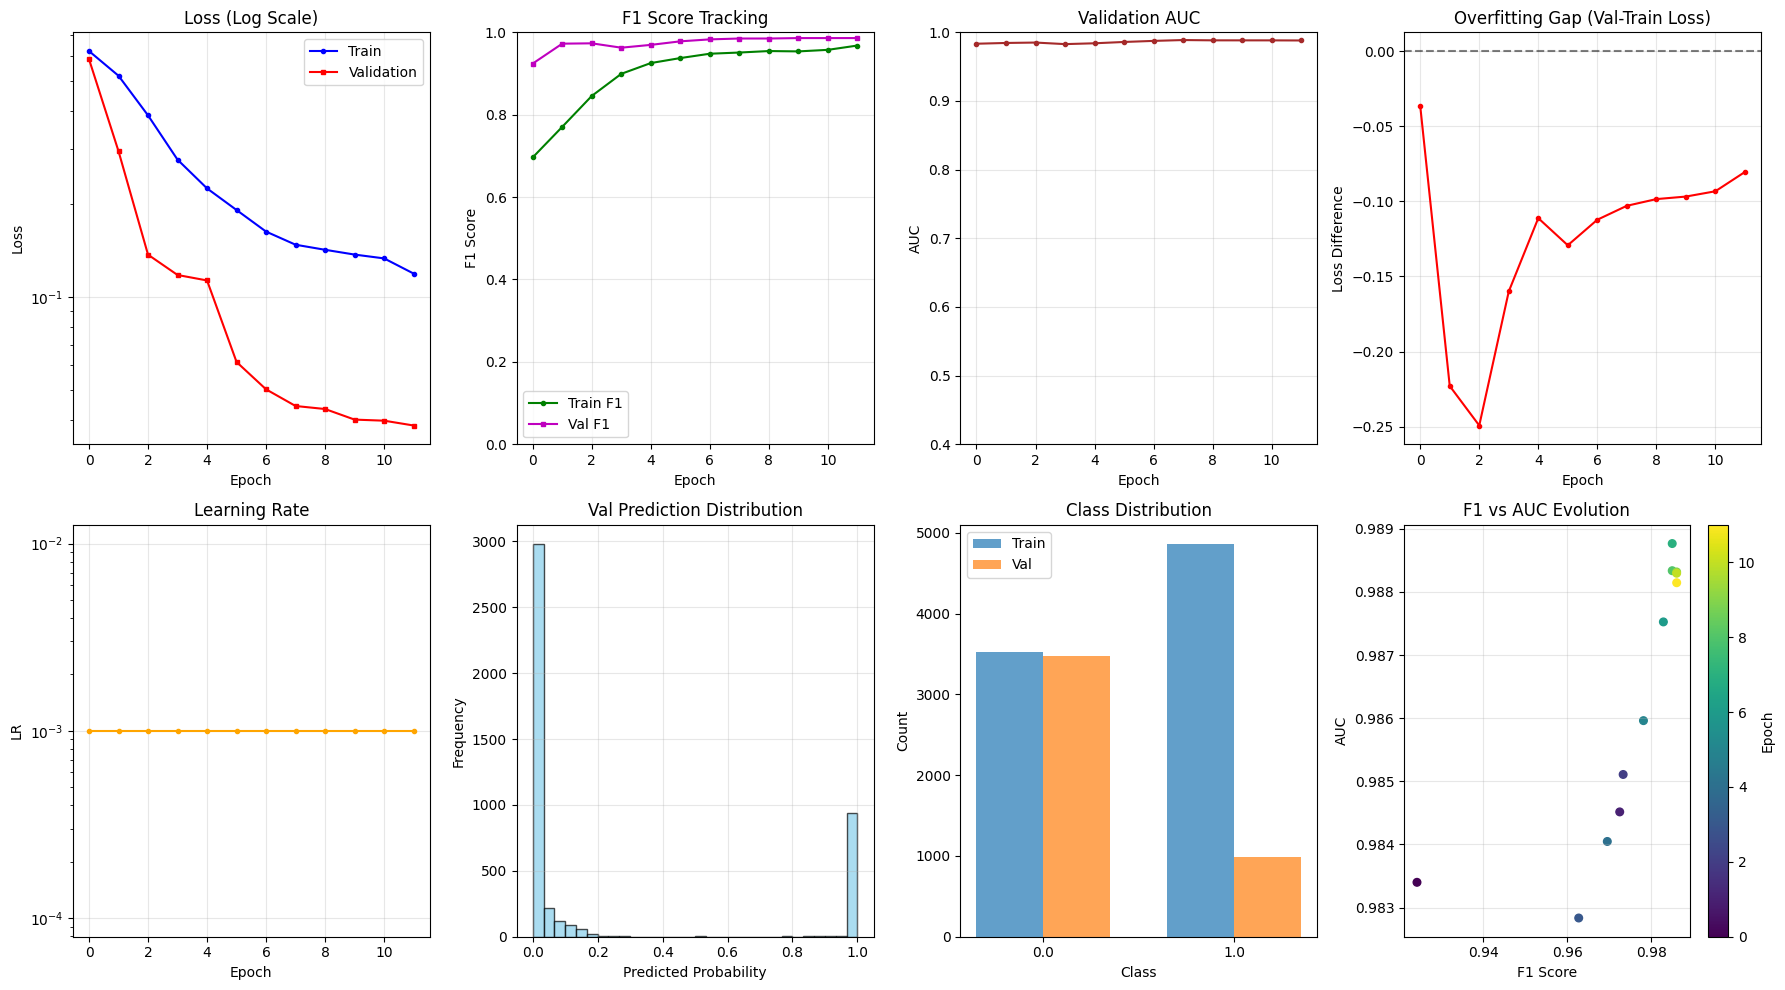

Epoch 13 | Loss: T=0.1183 V=0.0374 | F1: T=0.9671 V=0.9871 | AUC: 0.9881
    ✅ New best F1: 0.9871
Epoch 14 | Loss: T=0.1215 V=0.0373 | F1: T=0.9629 V=0.9856 | AUC: 0.9888
Epoch 15 | Loss: T=0.1162 V=0.0350 | F1: T=0.9680 V=0.9861 | AUC: 0.9891


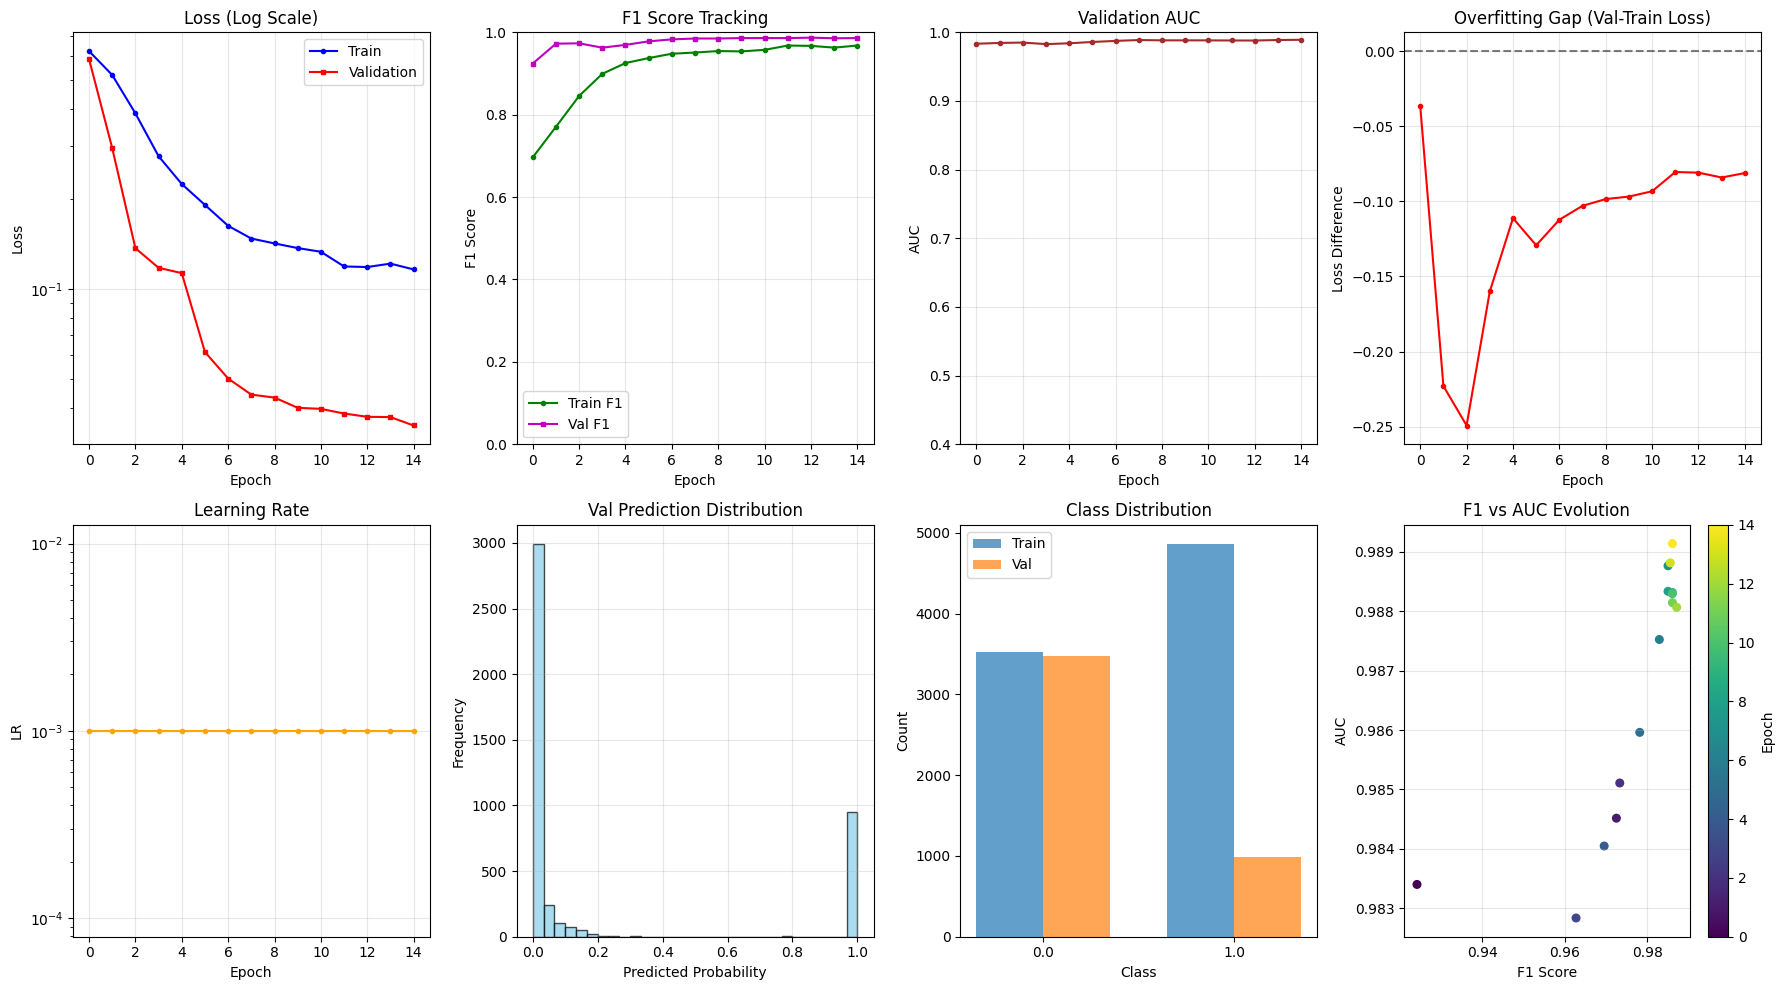

Epoch 16 | Loss: T=0.1121 V=0.0358 | F1: T=0.9715 V=0.9876 | AUC: 0.9888
    ✅ New best F1: 0.9876
Epoch 17 | Loss: T=0.1168 V=0.0326 | F1: T=0.9707 V=0.9887 | AUC: 0.9889
    ✅ New best F1: 0.9887
Epoch 18 | Loss: T=0.1168 V=0.0324 | F1: T=0.9716 V=0.9866 | AUC: 0.9884


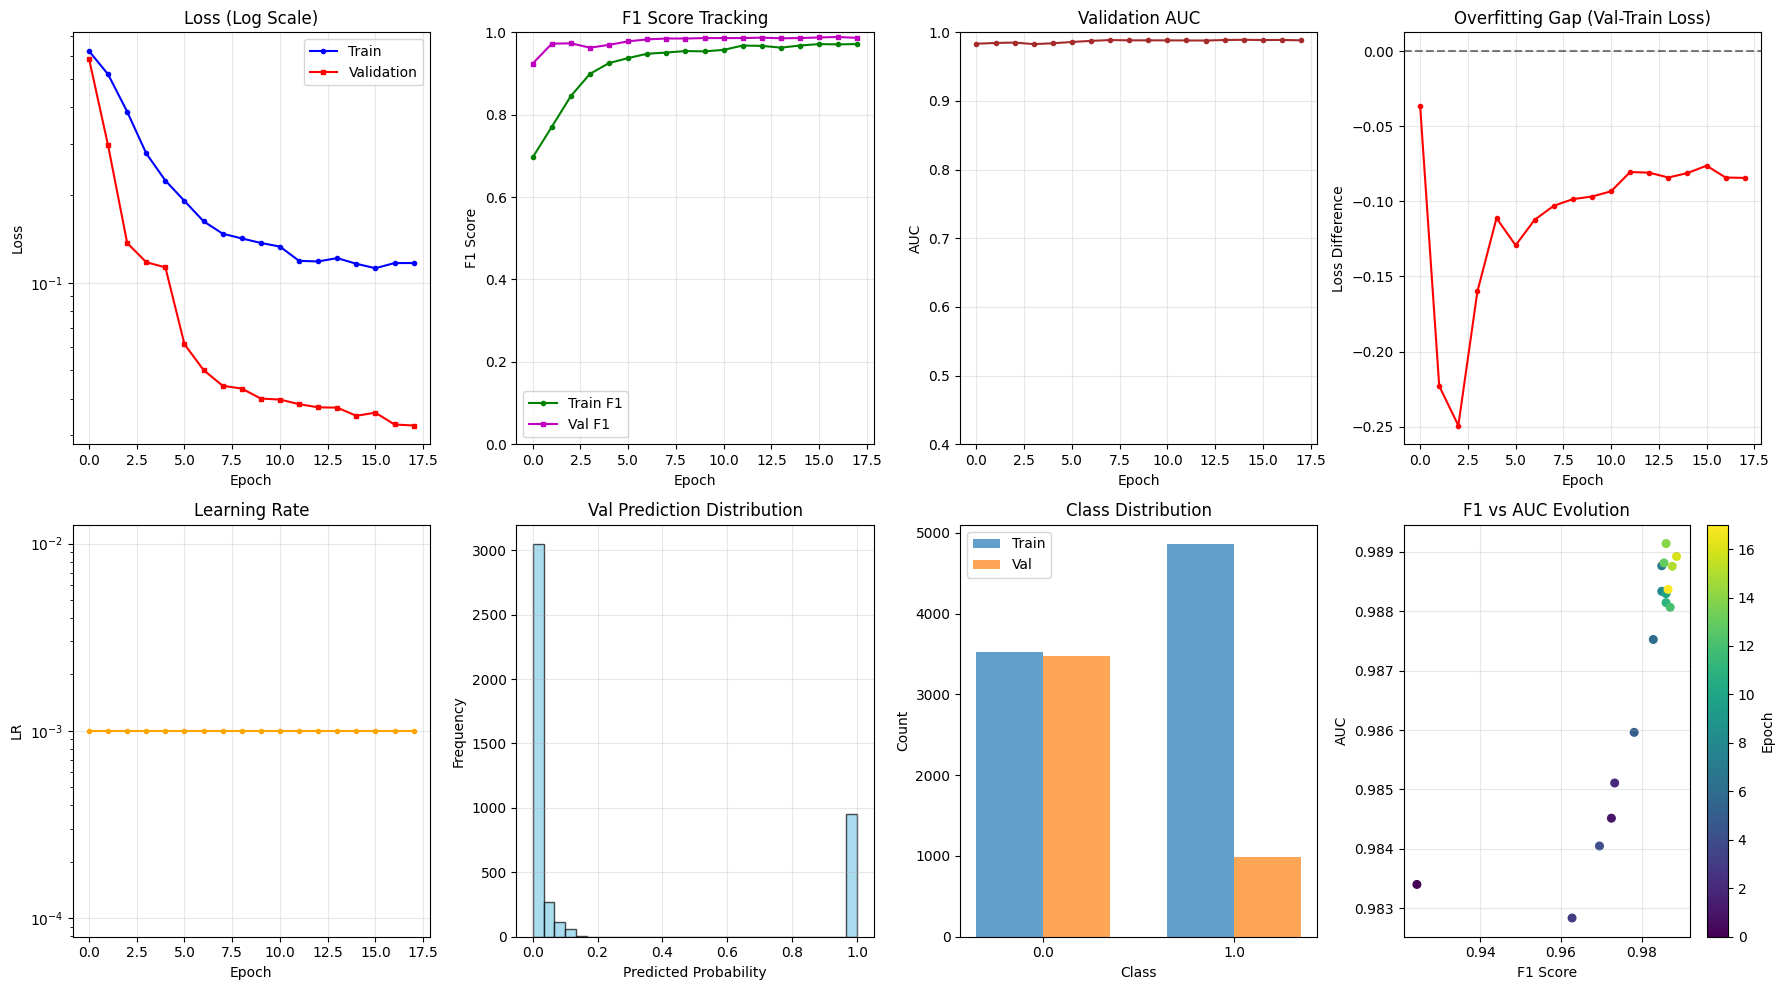

Epoch 19 | Loss: T=0.1097 V=0.0328 | F1: T=0.9728 V=0.9881 | AUC: 0.9899
Epoch 20 | Loss: T=0.1087 V=0.0310 | F1: T=0.9718 V=0.9881 | AUC: 0.9897
Epoch 21 | Loss: T=0.0997 V=0.0291 | F1: T=0.9736 V=0.9867 | AUC: 0.9920


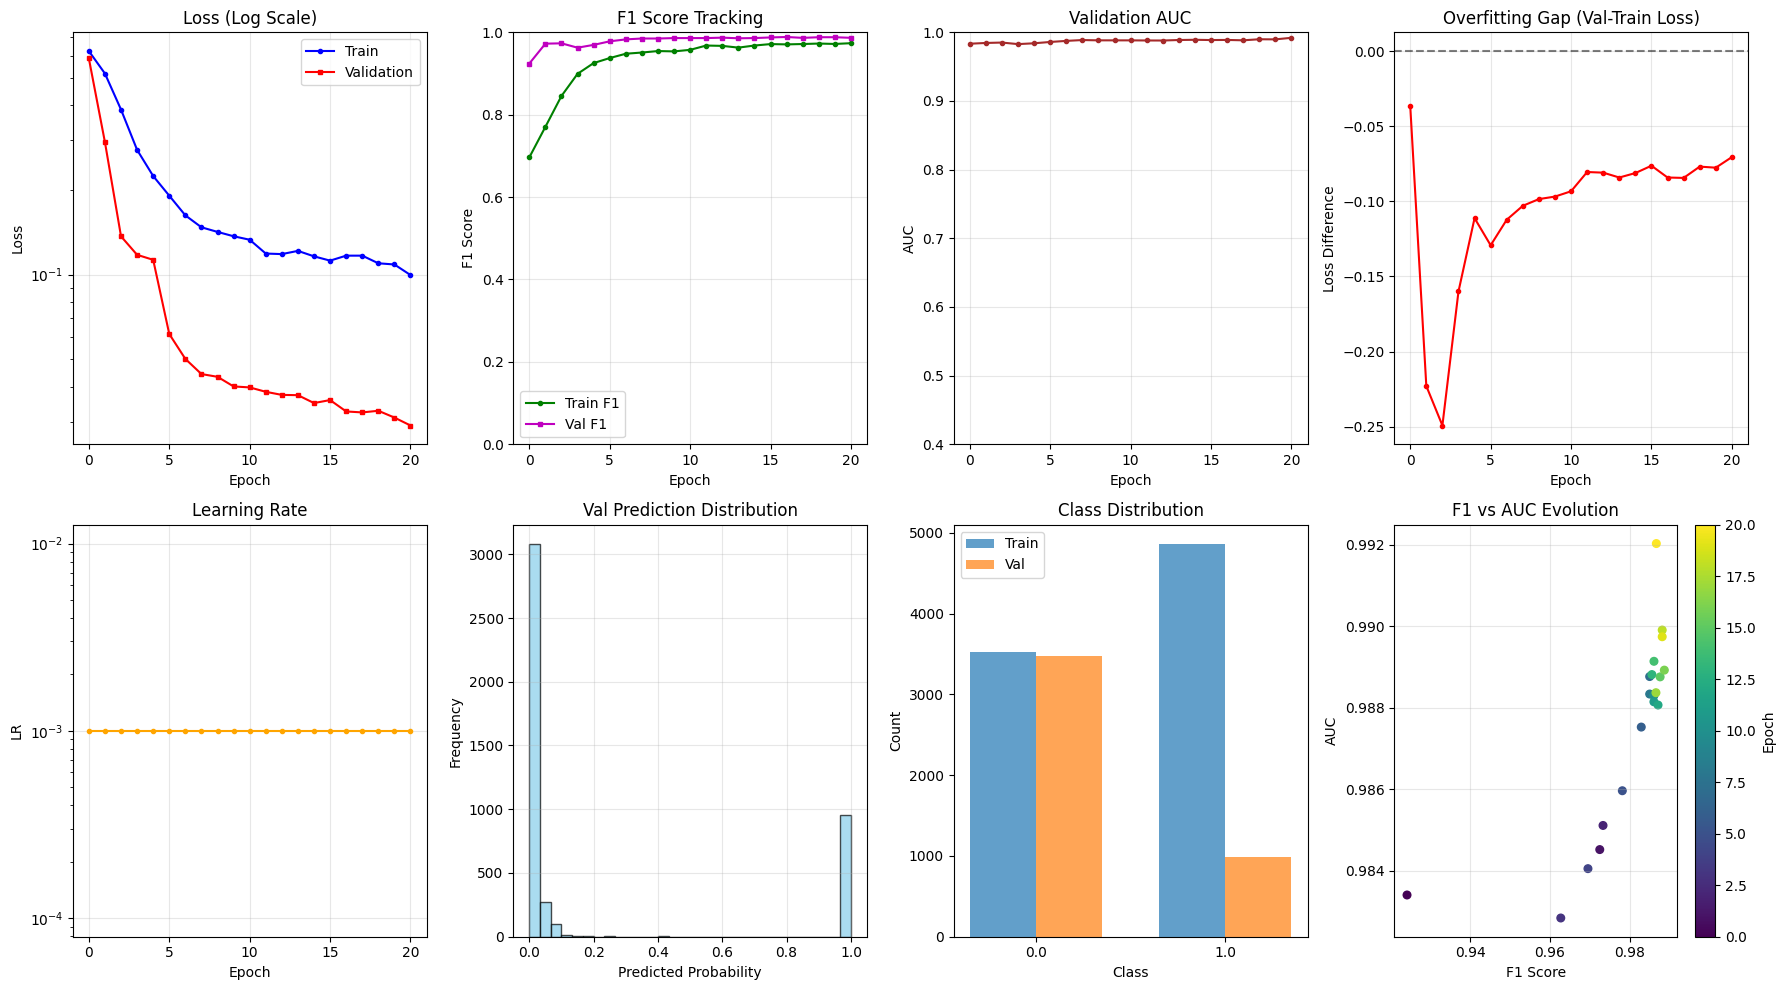

Epoch 22 | Loss: T=0.1080 V=0.0294 | F1: T=0.9750 V=0.9887 | AUC: 0.9896
Epoch 23 | Loss: T=0.1012 V=0.0298 | F1: T=0.9750 V=0.9887 | AUC: 0.9891
Epoch 24 | Loss: T=0.1071 V=0.0295 | F1: T=0.9749 V=0.9897 | AUC: 0.9896
    ✅ New best F1: 0.9897


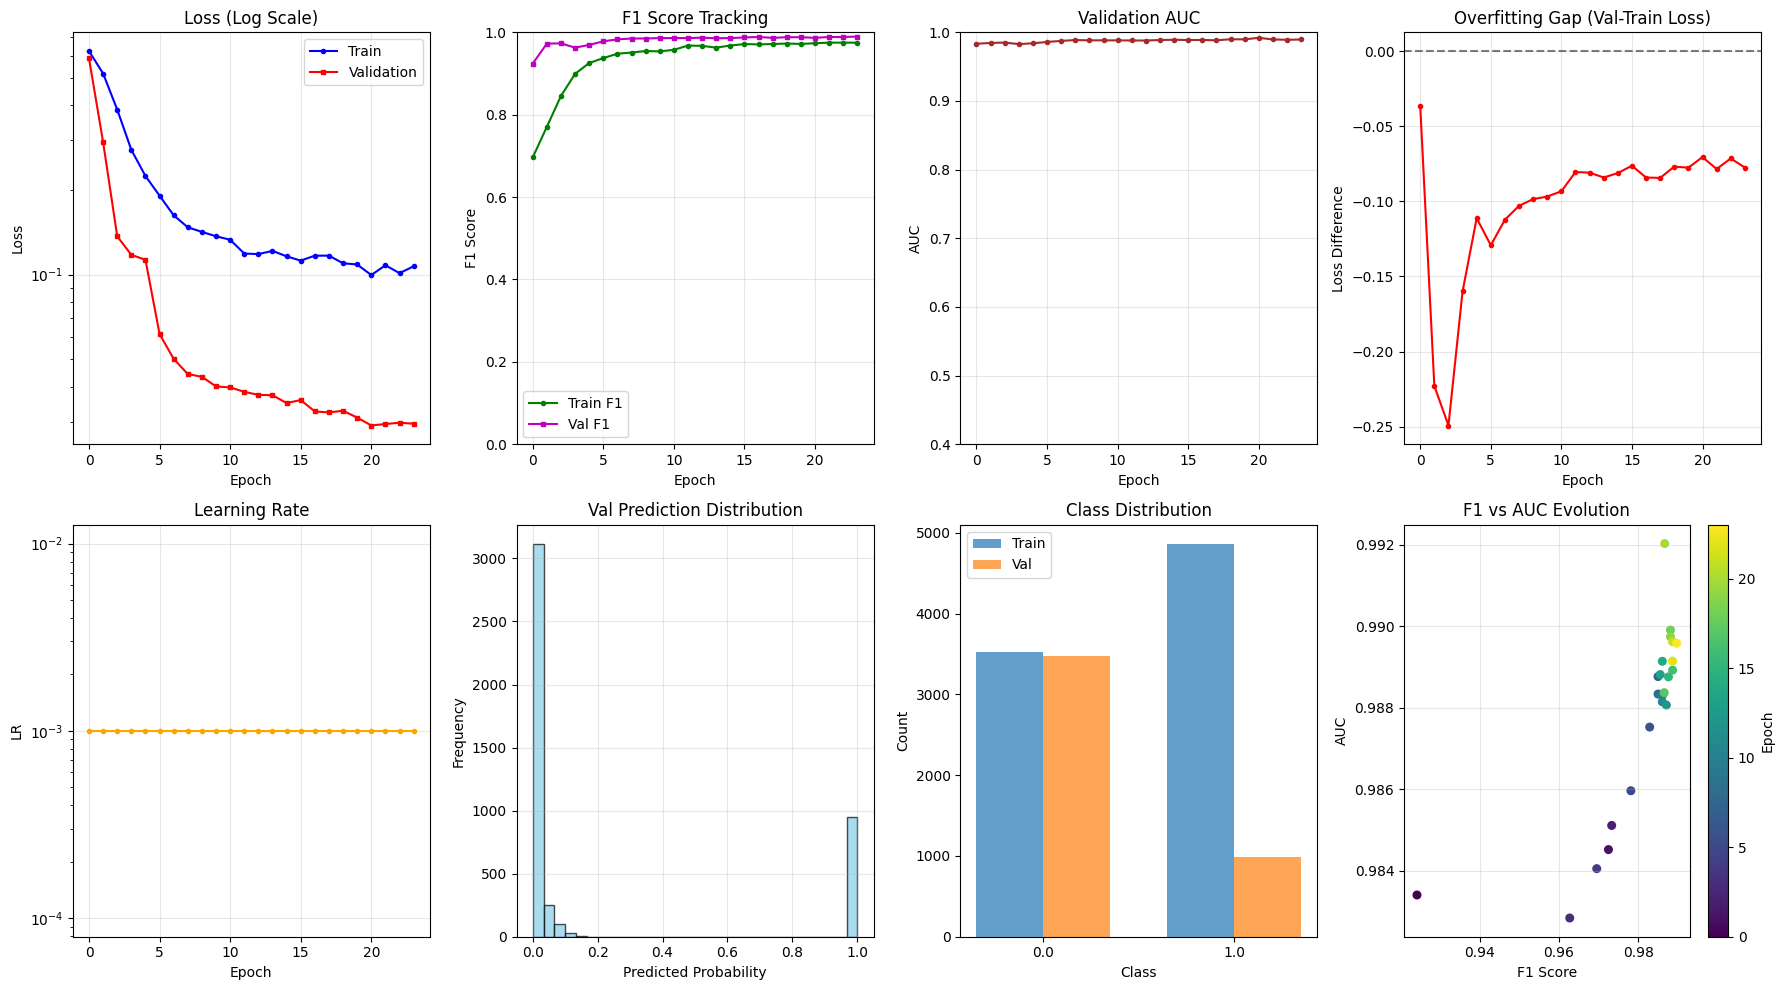

Epoch 25 | Loss: T=0.1034 V=0.0296 | F1: T=0.9752 V=0.9892 | AUC: 0.9895
Epoch 26 | Loss: T=0.1124 V=0.0287 | F1: T=0.9717 V=0.9913 | AUC: 0.9911
    ✅ New best F1: 0.9913
Epoch 27 | Loss: T=0.0985 V=0.0233 | F1: T=0.9773 V=0.9903 | AUC: 0.9938


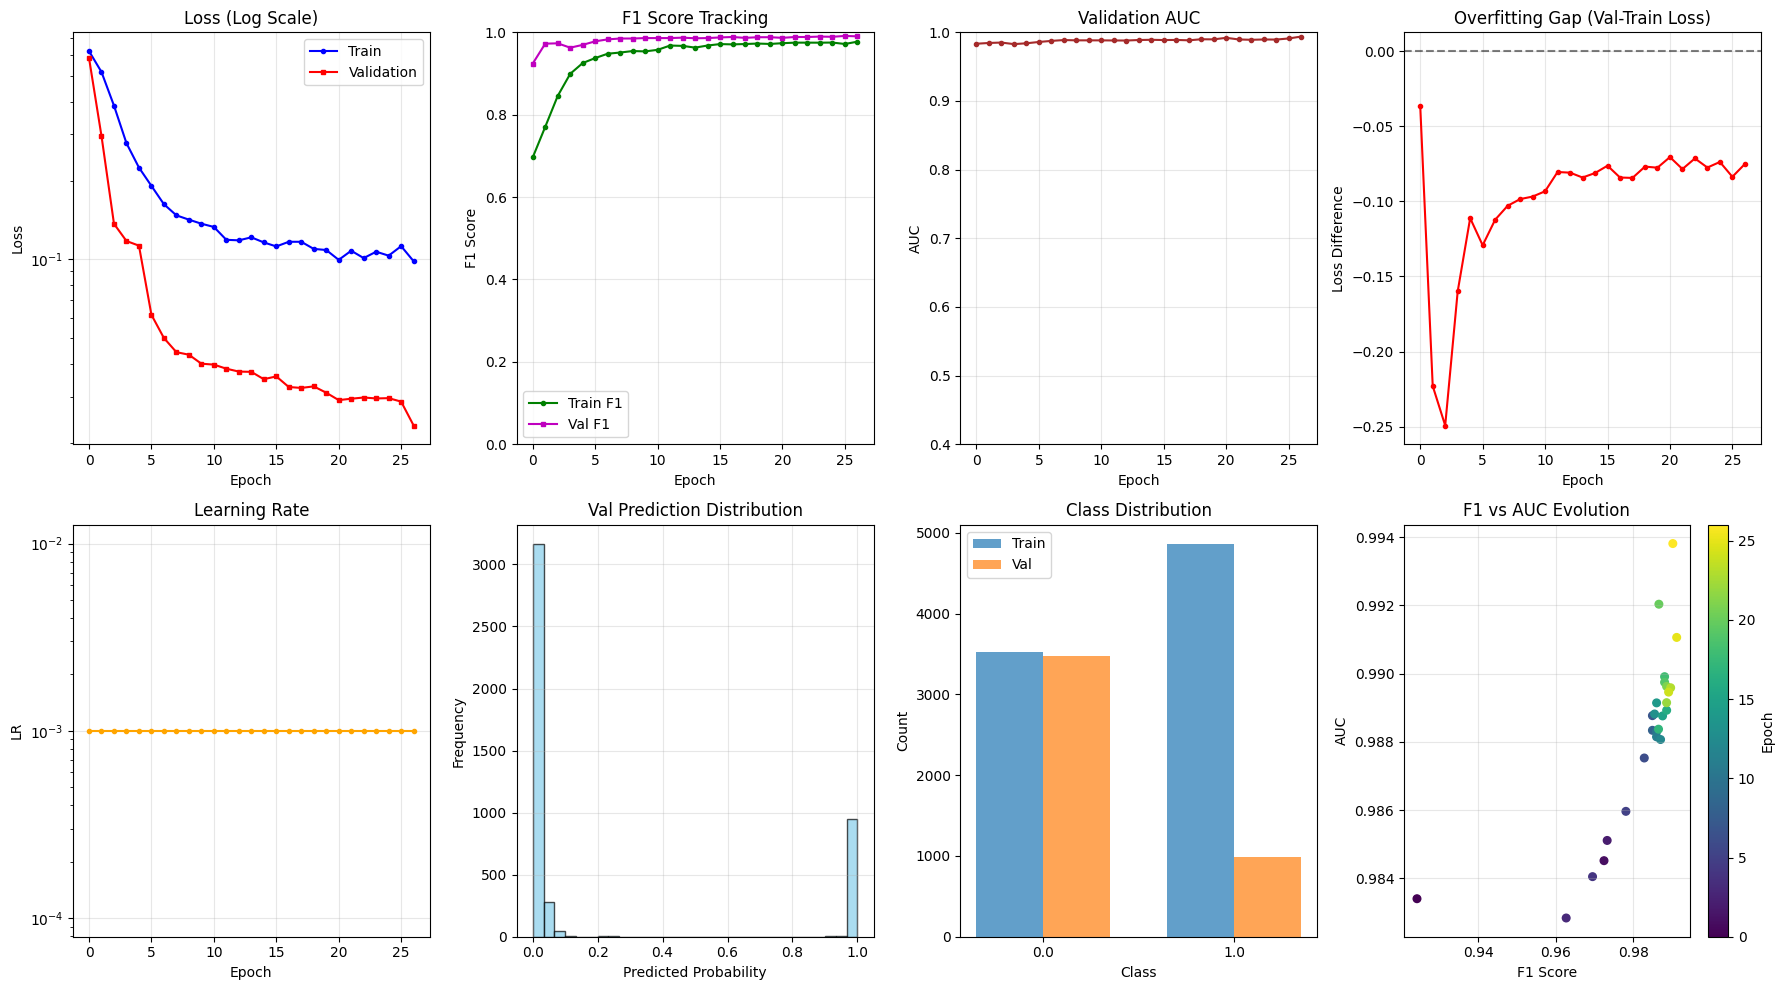

Epoch 28 | Loss: T=0.0985 V=0.0240 | F1: T=0.9769 V=0.9918 | AUC: 0.9933
    ✅ New best F1: 0.9918
Epoch 29 | Loss: T=0.0962 V=0.0215 | F1: T=0.9774 V=0.9908 | AUC: 0.9954
Epoch 30 | Loss: T=0.0886 V=0.0261 | F1: T=0.9790 V=0.9882 | AUC: 0.9906


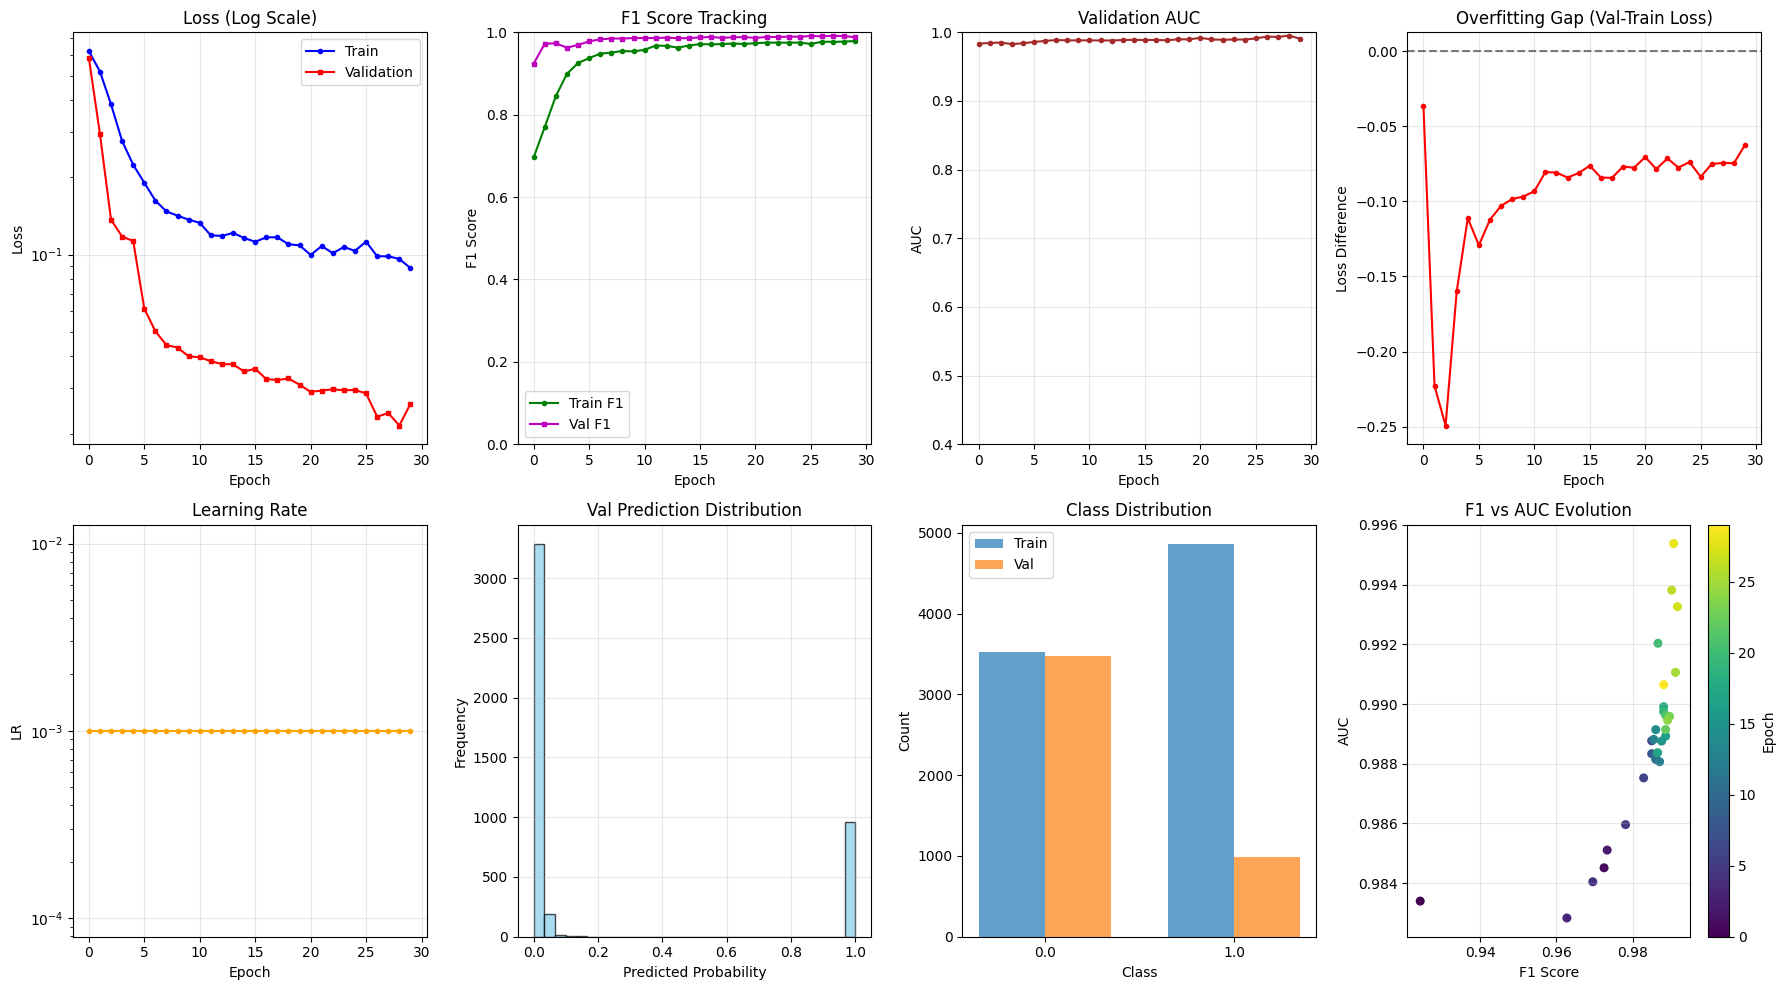

Epoch 31 | Loss: T=0.1038 V=0.0194 | F1: T=0.9789 V=0.9923 | AUC: 0.9957
    ✅ New best F1: 0.9923
Epoch 32 | Loss: T=0.0911 V=0.0206 | F1: T=0.9787 V=0.9933 | AUC: 0.9936
    ✅ New best F1: 0.9933
Epoch 33 | Loss: T=0.1118 V=0.0208 | F1: T=0.9767 V=0.9923 | AUC: 0.9931


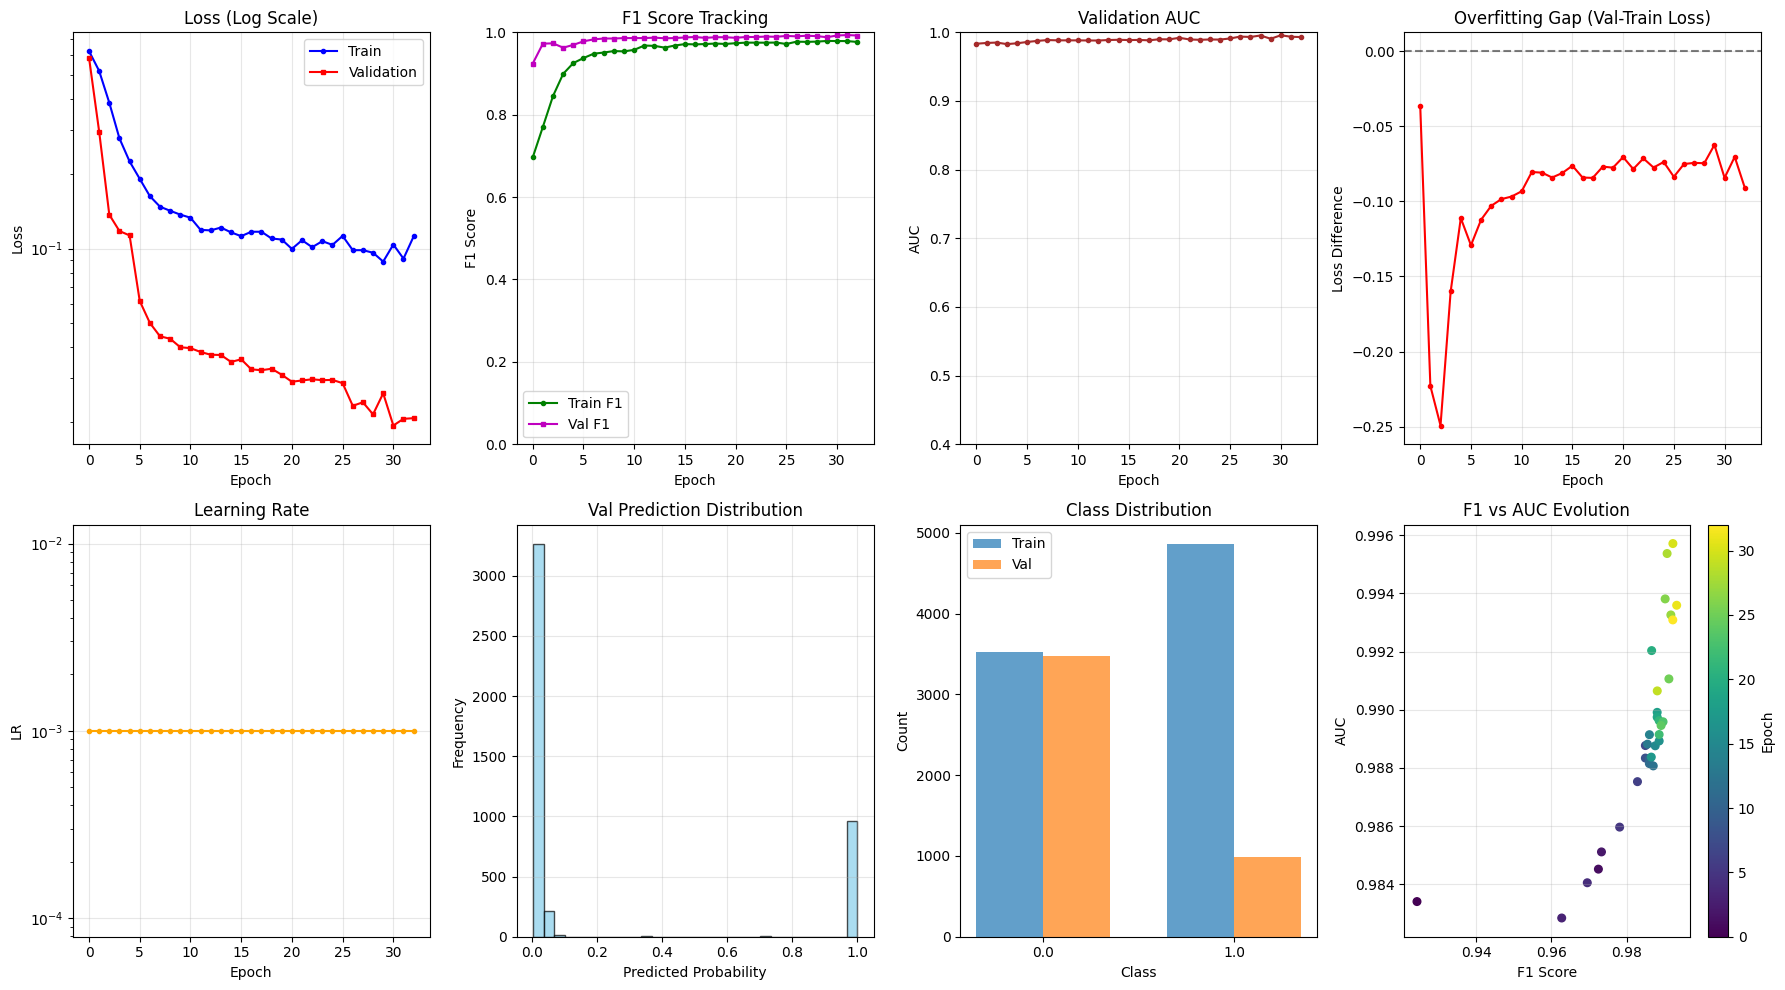

Epoch 34 | Loss: T=0.1138 V=0.0195 | F1: T=0.9761 V=0.9918 | AUC: 0.9960
Epoch 35 | Loss: T=0.0919 V=0.0247 | F1: T=0.9792 V=0.9902 | AUC: 0.9923
Epoch 36 | Loss: T=0.1007 V=0.0205 | F1: T=0.9763 V=0.9928 | AUC: 0.9942


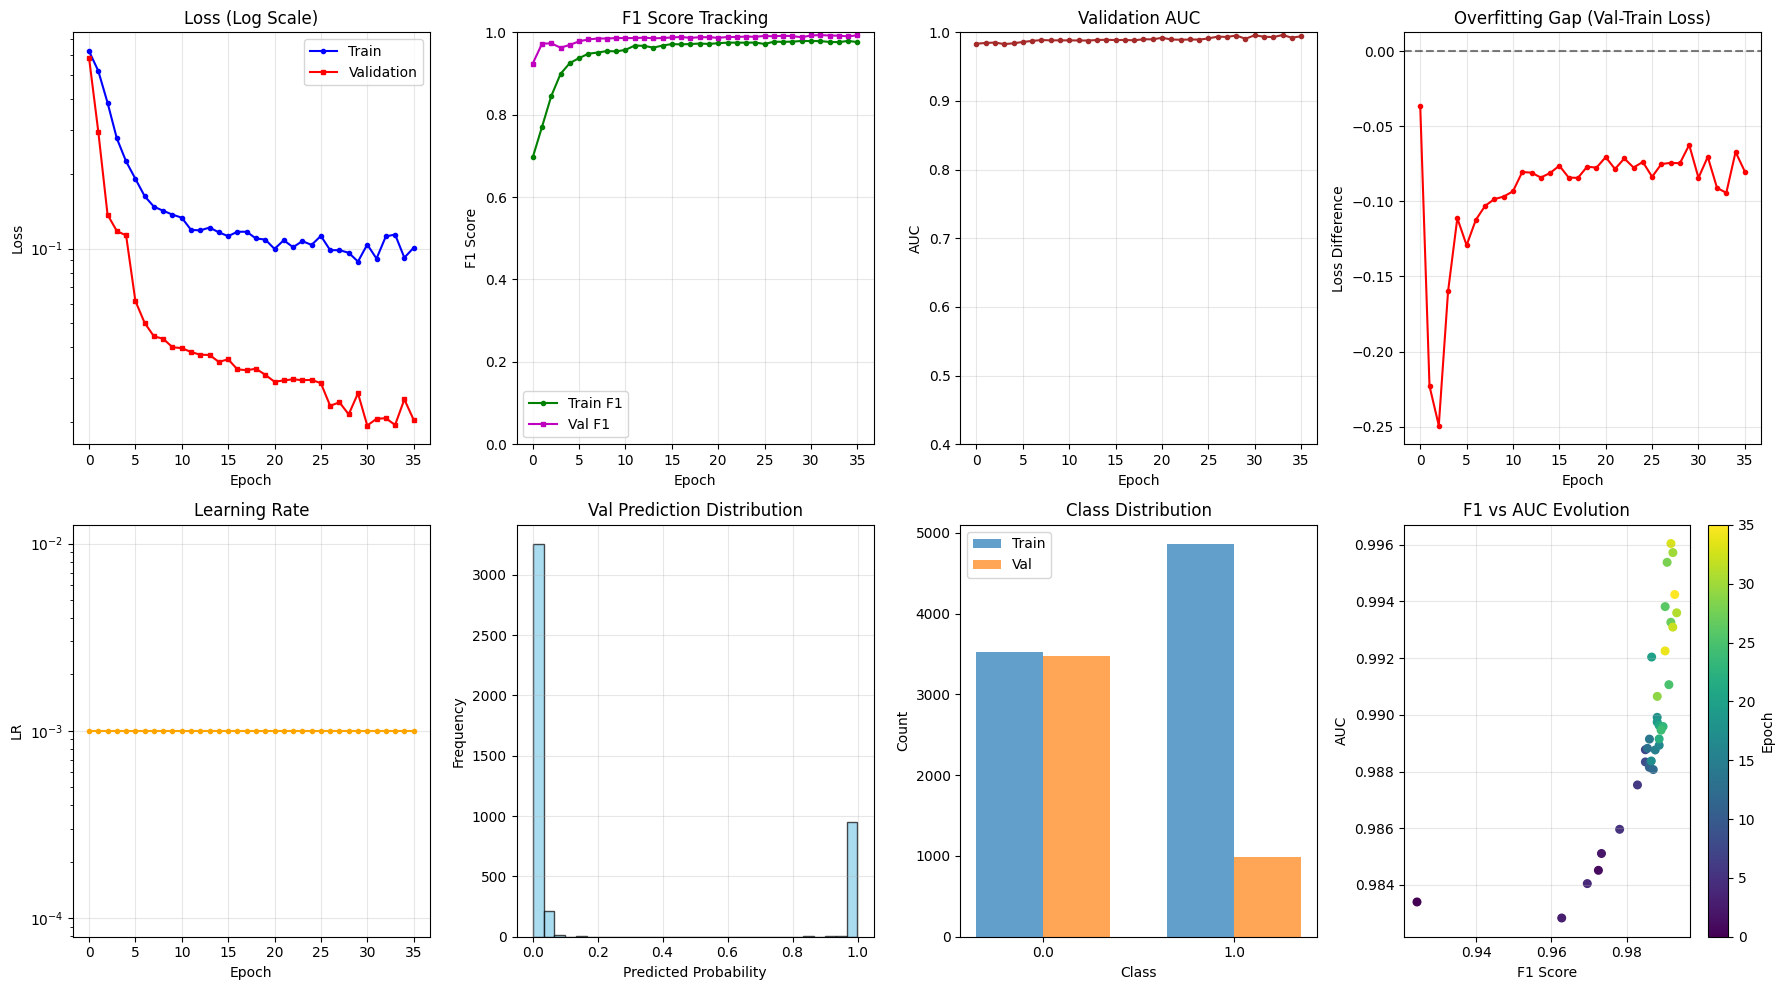

Epoch 37 | Loss: T=0.0959 V=0.0991 | F1: T=0.9800 V=0.9851 | AUC: 0.9920
Epoch 38 | Loss: T=0.1137 V=0.0510 | F1: T=0.9725 V=0.9856 | AUC: 0.9912
Epoch 39 | Loss: T=0.0885 V=0.0422 | F1: T=0.9779 V=0.9902 | AUC: 0.9942


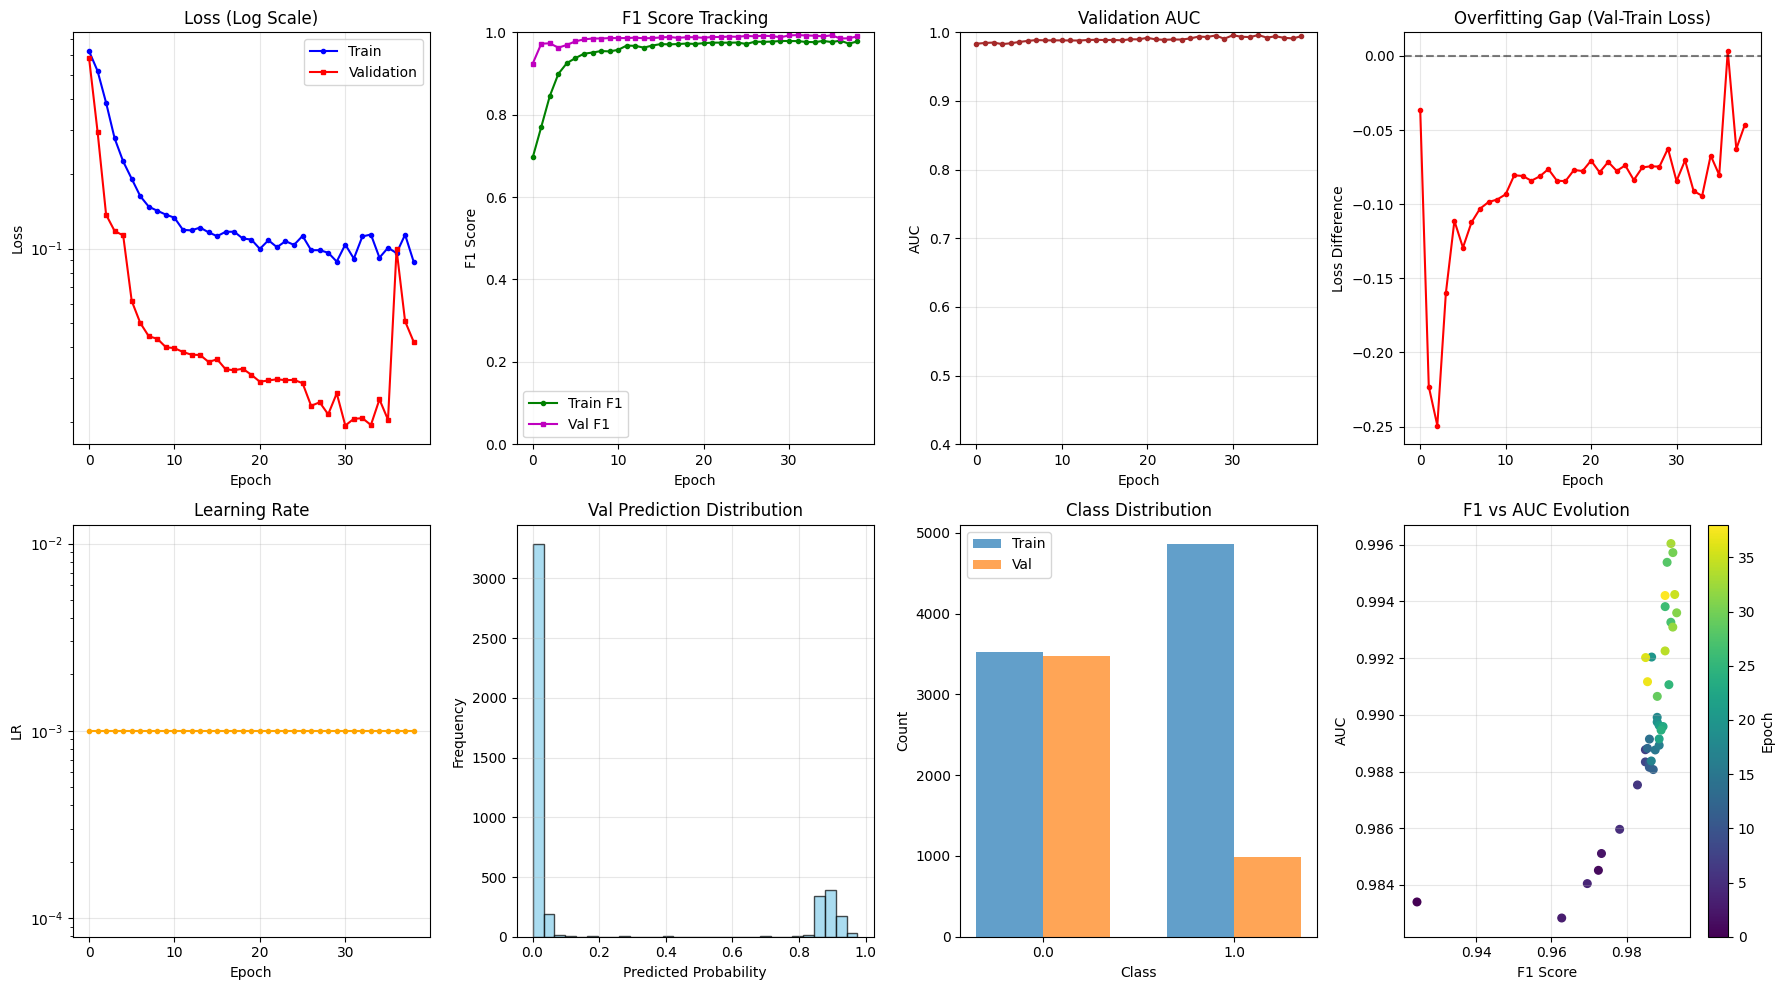

Epoch 40 | Loss: T=0.0839 V=0.0268 | F1: T=0.9792 V=0.9897 | AUC: 0.9929
Epoch 41 | Loss: T=0.0816 V=0.0233 | F1: T=0.9792 V=0.9882 | AUC: 0.9958
Epoch 42 | Loss: T=0.0873 V=0.0261 | F1: T=0.9809 V=0.9882 | AUC: 0.9947


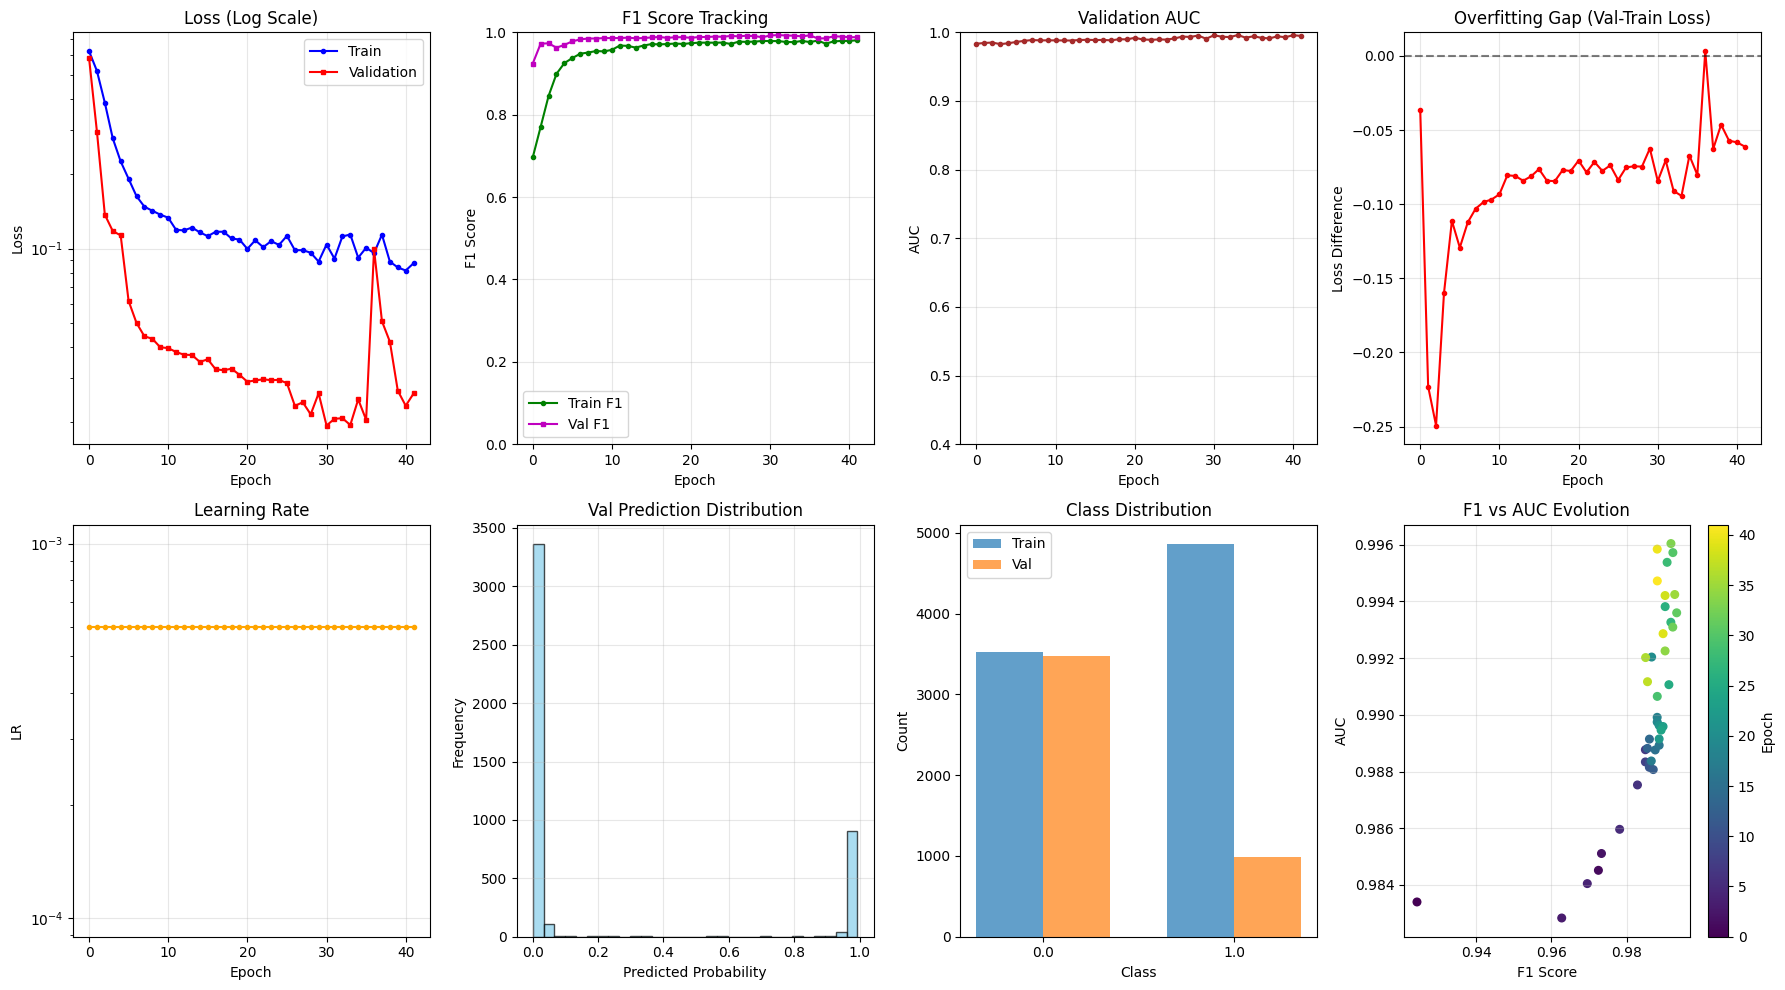

Epoch 43 | Loss: T=0.0806 V=0.0232 | F1: T=0.9790 V=0.9918 | AUC: 0.9961
Epoch 44 | Loss: T=0.0750 V=0.0557 | F1: T=0.9805 V=0.9857 | AUC: 0.9964
Epoch 45 | Loss: T=0.0780 V=0.0260 | F1: T=0.9823 V=0.9903 | AUC: 0.9948


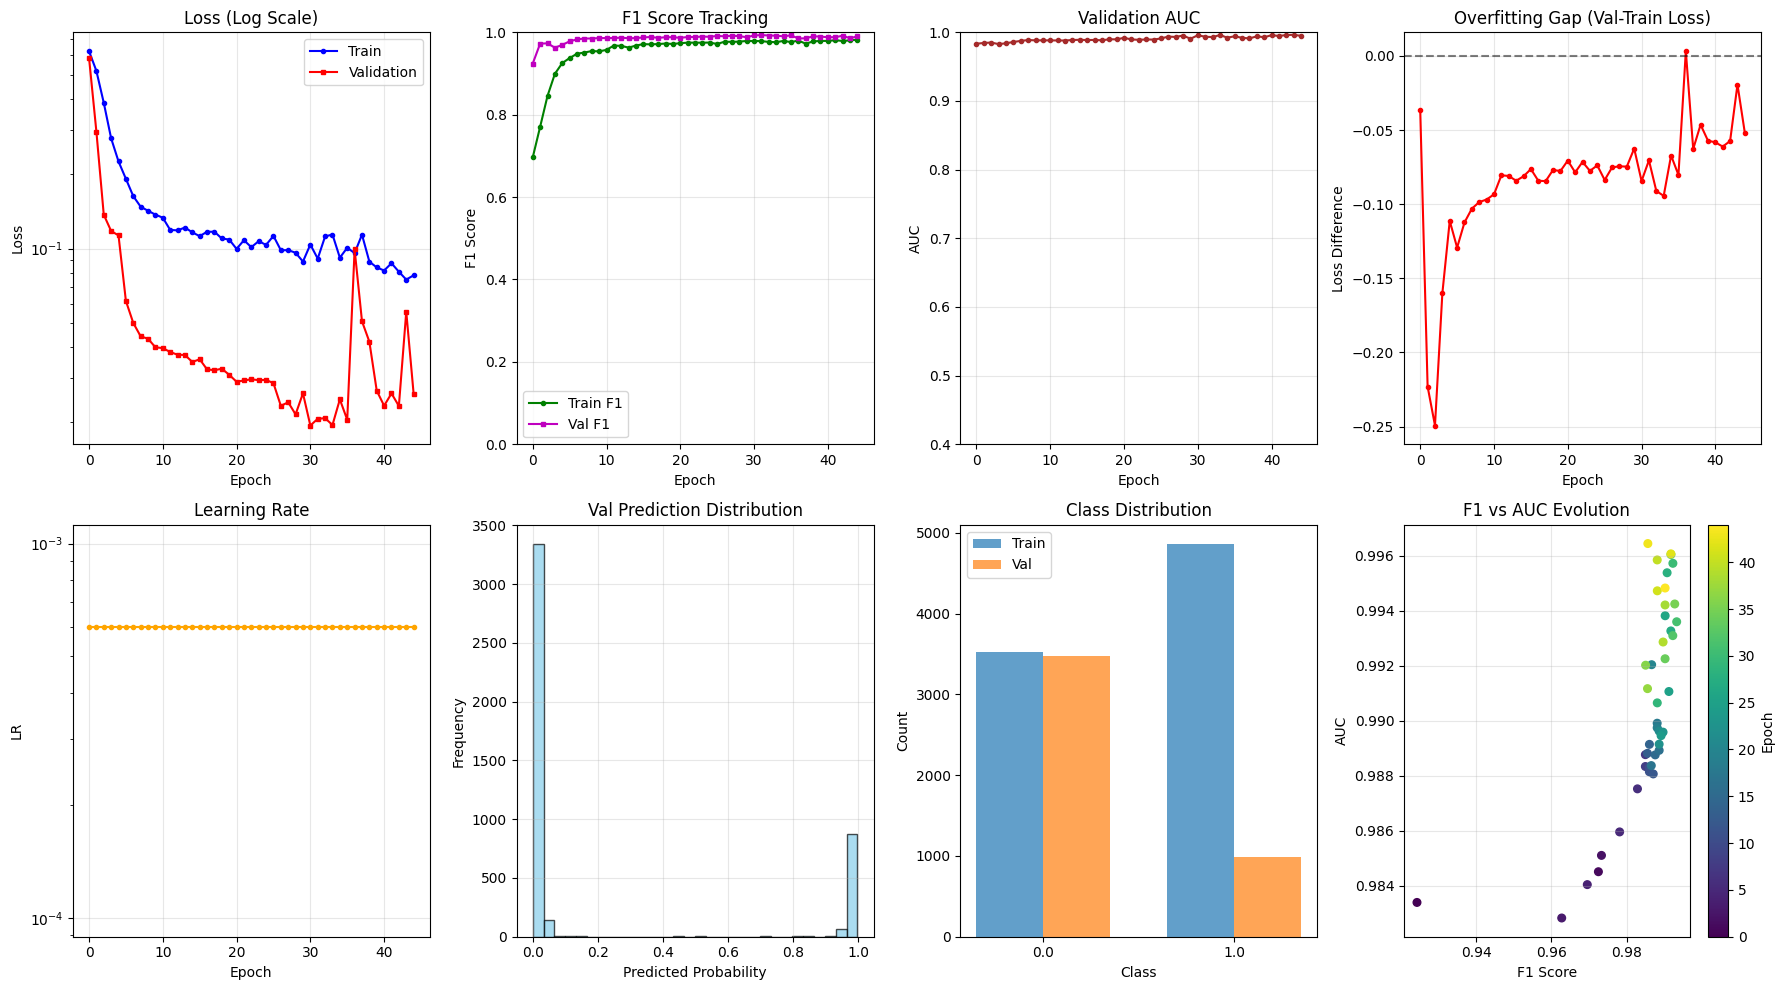

Epoch 46 | Loss: T=0.0821 V=0.0319 | F1: T=0.9795 V=0.9814 | AUC: 0.9935
Epoch 47 | Loss: T=0.0734 V=0.0231 | F1: T=0.9827 V=0.9876 | AUC: 0.9941
Epoch 48 | Loss: T=0.0741 V=0.0349 | F1: T=0.9821 V=0.9866 | AUC: 0.9938


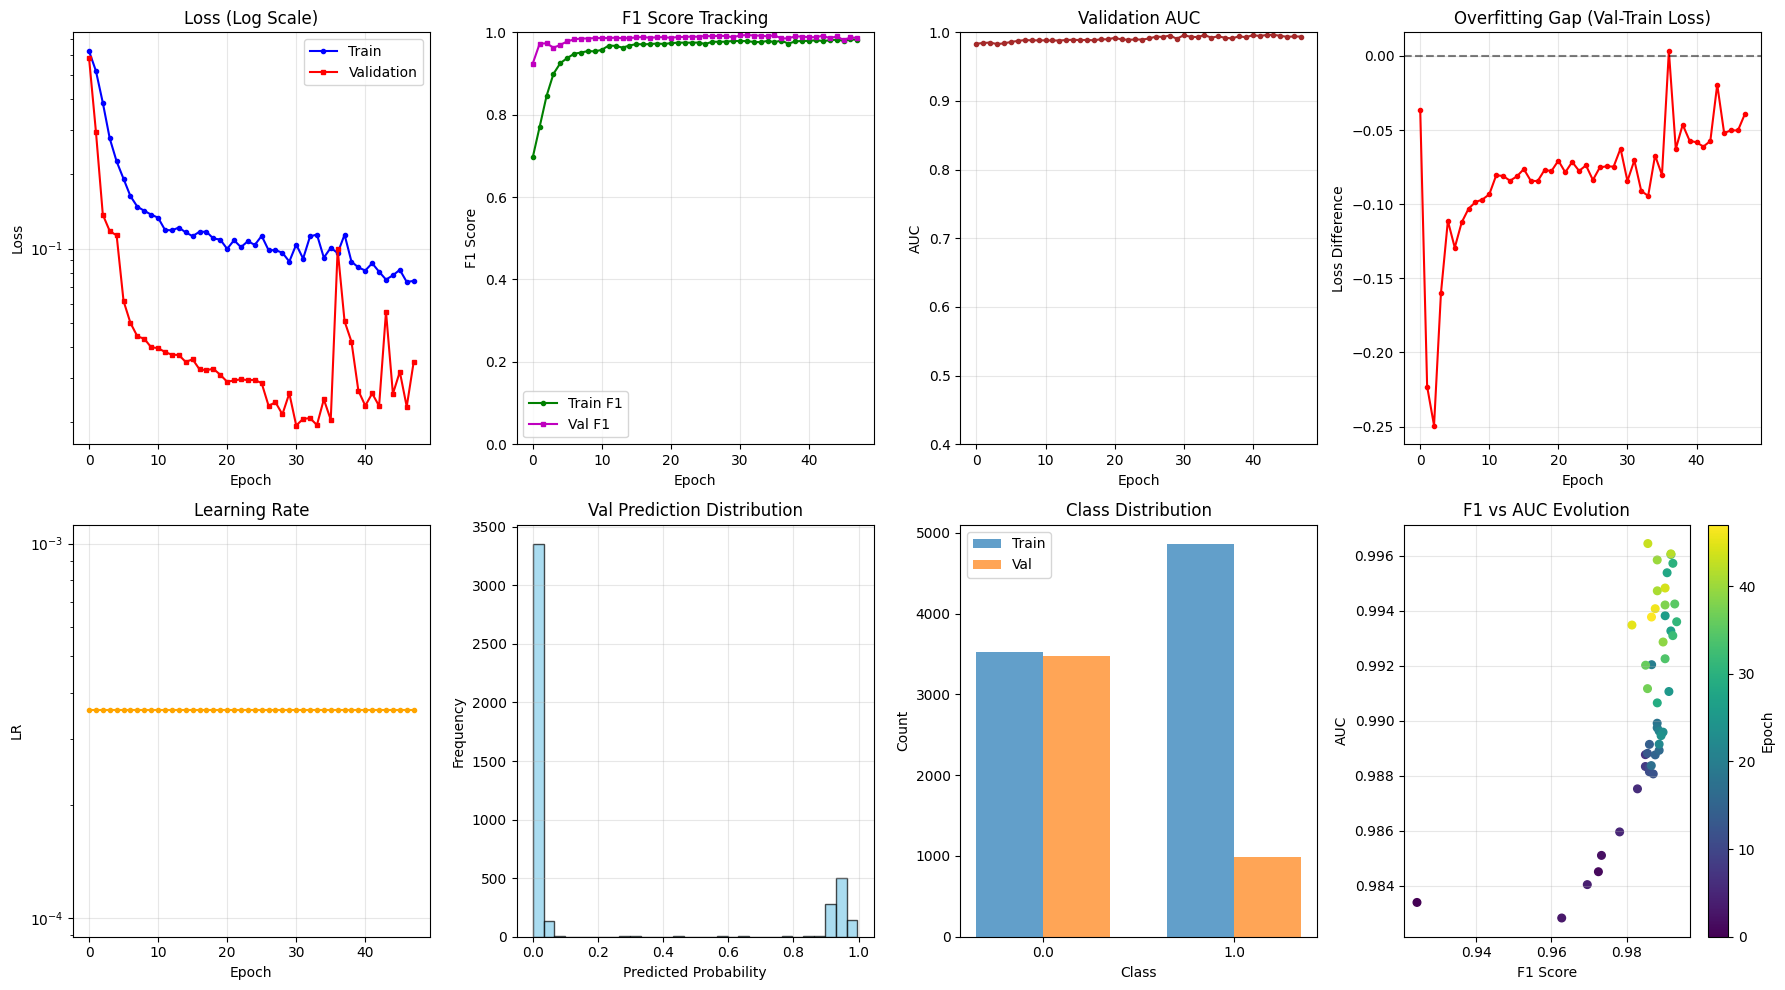

Epoch 49 | Loss: T=0.0676 V=0.0253 | F1: T=0.9841 V=0.9872 | AUC: 0.9951
Epoch 50 | Loss: T=0.0738 V=0.0211 | F1: T=0.9820 V=0.9887 | AUC: 0.9951
✅ Restored best model with validation F1: 0.9933

✅ Training completed!
Best validation F1: 0.9933
Best validation AUC: 0.9964

=== Final Test Evaluation ===
Using threshold: 0.5
Test Results:
  F1 Score: 0.8616
  AUC Score: 0.9359
  Test class distribution: {np.int64(0): np.int64(3746), np.int64(1): np.int64(704)}

Classification Report:
              precision    recall  f1-score   support

      Benign       0.97      0.97      0.97      3746
      Attack       0.87      0.86      0.86       704

    accuracy                           0.96      4450
   macro avg       0.92      0.92      0.92      4450
weighted avg       0.96      0.96      0.96      4450


=== Overfitting Analysis ===
Final loss ratio (Val/Train): 0.29
✅ Good loss ratio - minimal overfitting
F1 gap (Train - Val): -0.0092
✅ Good F1 generalization

=== Training Summary ===


In [ ]:
# ==============================
# STEP 7: ROBUST TRAINING FUNCTION (FIXED)
# ==============================
print("\n=== STEP 7: Robust LSTM Training ===")

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, classification_report

def train_lstm_robust_antioverfitting(X_train, y_train, X_val, y_val, params, model, epochs=30):
    """
    Robust training with comprehensive overfitting prevention
    """
    # Data preparation
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32)

    # NO SHUFFLING to preserve chronology
    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(
        train_dataset, batch_size=params['batch_size'], 
        shuffle=False, pin_memory=True, num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, batch_size=params['batch_size'],
        shuffle=False, pin_memory=True, num_workers=2
    )

    # Optimizer with weight decay
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['l2_reg']
    )

    # Conservative scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.6, 
        patience=params['reduce_lr_patience'], verbose=True
    )

    # Loss with class weights
    criterion = nn.BCEWithLogitsLoss(
        pos_weight=torch.tensor([params['pos_weight']], device=device)
    )

    # Tracking variables
    train_losses, val_losses = [], []
    train_f1s, val_f1s, val_aucs = [], [], []
    best_val_f1, patience_counter = 0, 0
    best_model_state = None

    print(f"Starting training: {epochs} epochs, patience={params['early_stopping_patience']}")

    for epoch in range(epochs):
        # =============
        # TRAINING
        # =============
        model.train()
        epoch_loss, train_preds_all, train_targets_all = 0, [], []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            
            # FIXED: Ensure proper shape matching
            if outputs.dim() > 1:
                outputs = outputs.squeeze(-1)  # Remove only last dimension if it exists
            if y_batch.dim() > 1:
                y_batch = y_batch.squeeze(-1)  # Remove only last dimension if it exists
                
            # Ensure both tensors have same shape
            if outputs.shape != y_batch.shape:
                print(f"Shape mismatch: outputs {outputs.shape}, targets {y_batch.shape}")
                # Try to fix by ensuring both are 1D
                outputs = outputs.view(-1)
                y_batch = y_batch.view(-1)
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), params['gradient_clip'])
            optimizer.step()

            epoch_loss += loss.item()
            
            # Collect training predictions
            with torch.no_grad():
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                preds = (probs >= 0.5).astype(int)
                train_preds_all.extend(preds)
                train_targets_all.extend(y_batch.cpu().numpy().flatten())

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Training F1
        train_f1 = f1_score(train_targets_all, train_preds_all, zero_division=0)
        train_f1s.append(train_f1)

        # =============
        # VALIDATION
        # =============
        model.eval()
        val_loss, val_probs_all, val_targets_all = 0, [], []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                
                # FIXED: Same shape fixing for validation
                if outputs.dim() > 1:
                    outputs = outputs.squeeze(-1)
                if y_batch.dim() > 1:
                    y_batch = y_batch.squeeze(-1)
                    
                # Ensure both tensors have same shape
                if outputs.shape != y_batch.shape:
                    outputs = outputs.view(-1)
                    y_batch = y_batch.view(-1)
                
                if not torch.isnan(outputs).any():
                    val_loss += criterion(outputs, y_batch).item()
                    probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                    val_probs_all.extend(probs)
                    val_targets_all.extend(y_batch.cpu().numpy().flatten())

        if len(val_probs_all) > 0:
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)
            
            val_probs_all = np.array(val_probs_all)
            val_targets_all = np.array(val_targets_all)
            
            # Calculate metrics
            if len(np.unique(val_targets_all)) > 1:
                val_auc = roc_auc_score(val_targets_all, val_probs_all)
            else:
                val_auc = 0.5
            val_aucs.append(val_auc)
            
            # Best F1 across thresholds
            best_val_f1_epoch = 0
            for thresh in np.arange(0.1, 0.9, 0.05):
                preds = (val_probs_all >= thresh).astype(int)
                f1 = f1_score(val_targets_all, preds, zero_division=0)
                best_val_f1_epoch = max(best_val_f1_epoch, f1)
            
            val_f1s.append(best_val_f1_epoch)

            # Print progress
            print(f"Epoch {epoch+1:2d} | Loss: T={avg_train_loss:.4f} V={avg_val_loss:.4f} | "
                  f"F1: T={train_f1:.4f} V={best_val_f1_epoch:.4f} | AUC: {val_auc:.4f}")

            # Early stopping
            if best_val_f1_epoch > best_val_f1 + params.get('min_delta', 1e-4):
                best_val_f1 = best_val_f1_epoch
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                patience_counter = 0
                print(f"    ✅ New best F1: {best_val_f1:.4f}")
            else:
                patience_counter += 1

            # Overfitting detection
            if len(train_losses) > 1 and len(val_losses) > 1:
                loss_gap = avg_val_loss - avg_train_loss
                if loss_gap > 0.05 and epoch > 5:
                    print(f"    ⚠️ Loss gap detected: {loss_gap:.4f}")

            # Learning rate scheduling
            scheduler.step(best_val_f1_epoch)

            if patience_counter >= params['early_stopping_patience']:
                print(f"⏹ Early stopping at epoch {epoch+1}")
                break

            # Enhanced plotting every 3 epochs
            if (epoch + 1) % 3 == 0 or epoch == 0:
                plt.figure(figsize=(18, 10))

                # 1. Loss with log scale
                plt.subplot(2, 4, 1)
                plt.plot(train_losses, 'b-o', label='Train', markersize=3)
                plt.plot(val_losses, 'r-s', label='Validation', markersize=3)
                plt.title("Loss (Log Scale)")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.yscale('log')
                plt.legend()
                plt.grid(True, alpha=0.3)

                # 2. F1 Score Comparison  
                plt.subplot(2, 4, 2)
                plt.plot(train_f1s, 'g-o', label='Train F1', markersize=3)
                plt.plot(val_f1s, 'm-s', label='Val F1', markersize=3)
                plt.title("F1 Score Tracking")
                plt.xlabel("Epoch")
                plt.ylabel("F1 Score")
                plt.ylim(0, 1)
                plt.legend()
                plt.grid(True, alpha=0.3)

                # 3. Validation AUC
                plt.subplot(2, 4, 3)
                plt.plot(val_aucs, 'brown', marker='o', markersize=3)
                plt.title("Validation AUC")
                plt.xlabel("Epoch")
                plt.ylabel("AUC")
                plt.ylim(0.4, 1.0)
                plt.grid(True, alpha=0.3)

                # 4. Overfitting indicator
                plt.subplot(2, 4, 4)
                if len(val_losses) == len(train_losses):
                    gap = np.array(val_losses) - np.array(train_losses)
                    plt.plot(gap, 'red', marker='o', markersize=3)
                    plt.title("Overfitting Gap (Val-Train Loss)")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss Difference")
                    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
                    plt.grid(True, alpha=0.3)

                # 5. Learning Rate
                plt.subplot(2, 4, 5)
                lrs = [group['lr'] for group in optimizer.param_groups]
                lr_history = [lrs[0]] * (epoch + 1)  # Simplified for this example
                plt.plot(lr_history, 'orange', marker='o', markersize=3)
                plt.title("Learning Rate")
                plt.xlabel("Epoch")
                plt.ylabel("LR")
                plt.yscale('log')
                plt.grid(True, alpha=0.3)

                # 6. Prediction Distribution
                plt.subplot(2, 4, 6)
                if len(val_probs_all) > 0:
                    plt.hist(val_probs_all, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
                plt.title("Val Prediction Distribution")
                plt.xlabel("Predicted Probability")
                plt.ylabel("Frequency")
                plt.grid(True, alpha=0.3)

                # 7. Class Balance
                plt.subplot(2, 4, 7)
                train_unique, train_counts = np.unique(train_targets_all, return_counts=True)
                val_unique, val_counts = np.unique(val_targets_all, return_counts=True)
                
                x_pos = np.arange(len(train_unique))
                width = 0.35
                plt.bar(x_pos - width/2, train_counts, width, label='Train', alpha=0.7)
                plt.bar(x_pos + width/2, val_counts, width, label='Val', alpha=0.7)
                plt.title("Class Distribution")
                plt.xlabel("Class")
                plt.ylabel("Count")
                plt.legend()
                plt.xticks(x_pos, train_unique)

                # 8. F1 vs AUC
                plt.subplot(2, 4, 8)
                if len(val_f1s) > 0 and len(val_aucs) > 0:
                    plt.scatter(val_f1s, val_aucs, c=range(len(val_f1s)), cmap='viridis', s=30)
                    plt.colorbar(label='Epoch')
                plt.title("F1 vs AUC Evolution")
                plt.xlabel("F1 Score")
                plt.ylabel("AUC")
                plt.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.show()

        else:
            print(f"⚠️ No valid validation data at epoch {epoch+1}")
            break

    # Restore best model
    if best_model_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        print(f"✅ Restored best model with validation F1: {best_val_f1:.4f}")
    else:
        print("⚠️ No improvement found, using final model")

    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'val_aucs': val_aucs
    }

# ==============================
# ADDITIONAL DEBUG FUNCTION
# ==============================

def debug_tensor_shapes(model, X_sample, y_sample):
    """
    Debug function to check tensor shapes
    """
    print("\n=== TENSOR SHAPE DEBUGGING ===")
    
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X_sample[:5].astype(np.float32)).to(device)
        y_tensor = torch.from_numpy(y_sample[:5].astype(np.float32)).to(device)
        
        print(f"Input X shape: {X_tensor.shape}")
        print(f"Input y shape: {y_tensor.shape}")
        
        outputs = model(X_tensor)
        print(f"Raw model output shape: {outputs.shape}")
        print(f"Raw model output: {outputs}")
        
        # Test different squeeze operations
        squeezed_once = outputs.squeeze(-1) if outputs.dim() > 1 else outputs
        print(f"After squeeze(-1): {squeezed_once.shape}")
        
        # What we need for loss function
        if y_tensor.dim() > 1:
            y_tensor_fixed = y_tensor.squeeze(-1)
        else:
            y_tensor_fixed = y_tensor
        print(f"Target tensor final shape: {y_tensor_fixed.shape}")
        
        # Test if they match now
        print(f"Shapes match: {squeezed_once.shape == y_tensor_fixed.shape}")
        
        return squeezed_once.shape, y_tensor_fixed.shape

# ==============================
# CREATE AND TRAIN MODEL
# ==============================
print("\n=== Creating Anti-Overfitting Model ===")

final_model = AdvancedLSTM(
    input_dim=X_train_seq.shape[2],
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    use_attention=best_params['use_attention'],
    bidirectional=best_params['bidirectional']
).to(device)

total_params = sum(p.numel() for p in final_model.parameters())
print(f"Model parameters: {total_params:,}")
print(f"Parameters per training sample: {total_params/len(X_train_seq):.2f}")

# Validate setup
print(f"Device: {device}")
test_tensor = torch.rand(10).to(device)
print(f"GPU test: {test_tensor.device}")

# ADDED: Debug tensor shapes before training
print("\n🔍 Debugging tensor shapes...")
debug_tensor_shapes(final_model, X_train_seq, y_train_seq)

# Execute robust training
print("\n🚀 Starting robust training...")
final_model, training_history = train_lstm_robust_antioverfitting(
    X_train_seq, y_train_seq, X_val_seq, y_val_seq,
    best_params, final_model, epochs=100
)

print(f"\n✅ Training completed!")
if training_history['val_f1s']:
    print(f"Best validation F1: {max(training_history['val_f1s']):.4f}")
    print(f"Best validation AUC: {max(training_history['val_aucs']):.4f}")

# ==============================
# FINAL TEST EVALUATION (FIXED)
# ==============================
print("\n=== Final Test Evaluation ===")

final_model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test_seq.astype(np.float32)).to(device)
    test_outputs = final_model(X_test_tensor)
    
    # FIXED: Proper shape handling for test outputs
    if test_outputs.dim() > 1:
        test_outputs = test_outputs.squeeze(-1)
    
    test_probs = torch.sigmoid(test_outputs).cpu().numpy().flatten()

# Find optimal threshold on validation set
if len(training_history['val_f1s']) > 0:
    # Use a simple threshold for now
    optimal_threshold = 0.5
    print(f"Using threshold: {optimal_threshold}")
    
    test_preds = (test_probs >= optimal_threshold).astype(int)
    
    # Calculate test metrics
    test_f1 = f1_score(y_test_seq, test_preds, zero_division=0)
    if len(np.unique(y_test_seq)) > 1:
        test_auc = roc_auc_score(y_test_seq, test_probs)
    else:
        test_auc = 0.5
    
    print(f"Test Results:")
    print(f"  F1 Score: {test_f1:.4f}")
    print(f"  AUC Score: {test_auc:.4f}")
    
    # Test set class distribution
    test_unique, test_counts = np.unique(y_test_seq, return_counts=True)
    print(f"  Test class distribution: {dict(zip(test_unique, test_counts))}")
    
    # Detailed classification report
    if len(np.unique(y_test_seq)) > 1:
        print("\nClassification Report:")
        print(classification_report(y_test_seq, test_preds, target_names=['Benign', 'Attack']))

# ==============================
# OVERFITTING ANALYSIS
# ==============================
print("\n=== Overfitting Analysis ===")

if len(training_history['train_losses']) > 5 and len(training_history['val_losses']) > 5:
    final_train_loss = training_history['train_losses'][-1]
    final_val_loss = training_history['val_losses'][-1]
    min_train_loss = min(training_history['train_losses'])
    
    loss_ratio = final_val_loss / final_train_loss
    print(f"Final loss ratio (Val/Train): {loss_ratio:.2f}")
    
    if loss_ratio > 3:
        print("🚨 HIGH overfitting detected (Val loss >> Train loss)")
    elif loss_ratio > 1.5:
        print("⚠️ Moderate overfitting detected")
    else:
        print("✅ Good loss ratio - minimal overfitting")
    
    # Check for training loss collapse
    if min_train_loss < 0.01:
        print("⚠️ Training loss very low - possible memorization")
    
    # F1 gap analysis
    if training_history['train_f1s'] and training_history['val_f1s']:
        f1_gap = max(training_history['train_f1s']) - max(training_history['val_f1s'])
        print(f"F1 gap (Train - Val): {f1_gap:.4f}")
        
        if f1_gap > 0.2:
            print("🚨 Large F1 gap - significant overfitting")
        elif f1_gap > 0.1:
            print("⚠️ Moderate F1 gap")
        else:
            print("✅ Good F1 generalization")

print("\n=== Training Summary ===")
print("If you're still seeing overfitting:")
print("1. Reduce hidden_dim further (try 32 or 16)")
print("2. Increase dropout to 0.6-0.8") 
print("3. Reduce sequence length")
print("4. Add more data augmentation")
print("5. Consider simpler models (non-LSTM)")

# Save model
torch.save(final_model.state_dict(), "robust_lstm_model.pth")
print("💾 Model saved as robust_lstm_model.pth")

In [138]:
# ==============================
# STEP 8: Comprehensive Evaluation with Debugging
# ==============================
print("\n=== STEP 8: Final Model Evaluation with Debugging ===")
lstm_results = None #temp

try:
    # Test evaluation with debugging
    test_dataset = TensorDataset(torch.FloatTensor(X_test_seq), torch.FloatTensor(y_test_seq))
    test_loader = DataLoader(test_dataset, batch_size=min(64, len(X_test_seq)), shuffle=False)
        
    final_model.eval()
    test_probs = []
    test_targets = []
    all_outputs = []
        
    print("Evaluating model on test set...")
    with torch.no_grad():
        for i, (batch_X, batch_y) in enumerate(test_loader):
            batch_X = batch_X.to(device)
            outputs = final_model(batch_X)
                
            # Debug model outputs
            if i == 0:  # First batch debugging
                print(f"First batch outputs shape: {outputs.shape}")
                print(f"Output range: [{outputs.min().item():.4f}, {outputs.max().item():.4f}]")
                print(f"Output mean: {outputs.mean().item():.4f}")
                print(f"Output std: {outputs.std().item():.4f}")
                
            all_outputs.extend(outputs.cpu().numpy())
                
            if not torch.isnan(outputs).any() and not torch.isinf(outputs).any():
                probs = torch.sigmoid(outputs).cpu().numpy()
                test_probs.extend(probs)
                test_targets.extend(batch_y.numpy())
            else:
                print(f"⚠️  NaN or Inf detected in batch {i}")
        
    test_probs = np.array(test_probs).flatten()
    test_targets = np.array(test_targets)
    all_outputs = np.array(all_outputs).flatten()
        
    print(f"\nModel output analysis:")
    print(f"Raw outputs - Min: {all_outputs.min():.4f}, Max: {all_outputs.max():.4f}")
    print(f"Raw outputs - Mean: {all_outputs.mean():.4f}, Std: {all_outputs.std():.4f}")
    print(f"Probabilities - Min: {test_probs.min():.4f}, Max: {test_probs.max():.4f}")
    print(f"Probabilities - Mean: {test_probs.mean():.4f}, Std: {test_probs.std():.4f}")
        
    # Check for constant predictions
    if test_probs.std() < 1e-6:
        print("🚨 CRITICAL ISSUE: Model is making constant predictions!")
        print("   All probabilities are essentially the same")
        print("   This explains the stagnant metrics")
        print("   Model failed to learn meaningful patterns")
        
    # Find optimal threshold
    if len(np.unique(test_targets)) > 1 and test_probs.std() > 1e-6:
        thresholds = np.linspace(0.01, 0.99, 100)
        f1_scores = []
        for t in thresholds:
            preds = (test_probs >= t).astype(int)
            f1 = f1_score(test_targets, preds, zero_division=0)
            f1_scores.append(f1)
            
        best_threshold_idx = np.argmax(f1_scores)
        best_threshold = thresholds[best_threshold_idx]
        best_f1 = f1_scores[best_threshold_idx]
            
        print(f"Threshold optimization:")
        print(f"  Best threshold: {best_threshold:.4f}")
        print(f"  Best F1 at threshold: {best_f1:.4f}")
    else:
        best_threshold = 0.5
        print("Using default threshold: 0.5")
        
    y_pred_final = (test_probs >= best_threshold).astype(int)
        
    # Calculate metrics with debugging
    print(f"\nPrediction analysis:")
    pred_unique, pred_counts = np.unique(y_pred_final, return_counts=True)
    print(f"Predictions distribution: {dict(zip(pred_unique, pred_counts))}")
    target_unique, target_counts = np.unique(test_targets, return_counts=True)
    print(f"Targets distribution: {dict(zip(target_unique, target_counts))}")
        
    # Calculate metrics
    lstm_results = {
        'accuracy': accuracy_score(test_targets, y_pred_final),
        'f1': f1_score(test_targets, y_pred_final, zero_division=0),
        'precision': precision_score(test_targets, y_pred_final, zero_division=0),
        'recall': recall_score(test_targets, y_pred_final, zero_division=0),
        'best_threshold': best_threshold
    }
        
    if len(np.unique(test_targets)) > 1 and test_probs.std() > 1e-6:
        try:
            lstm_results['auc'] = roc_auc_score(test_targets, test_probs)
            lstm_results['pr_auc'] = average_precision_score(test_targets, test_probs)
        except:
            lstm_results['auc'] = 0.5
            lstm_results['pr_auc'] = 0.5
            print("⚠️  Could not calculate AUC scores")
    else:
        lstm_results['auc'] = 0.5
        lstm_results['pr_auc'] = 0.5
        
    print(f"\n=== Chronological LSTM Results ===")
    print(f"Accuracy:  {lstm_results['accuracy']:.4f}")
    print(f"AUC:       {lstm_results['auc']:.4f}")
    print(f"F1 Score:  {lstm_results['f1']:.4f}")
    print(f"Precision: {lstm_results['precision']:.4f}")
    print(f"Recall:    {lstm_results['recall']:.4f}")
        
    # Enhanced reality check
    if lstm_results['f1'] == 0:
        print("\n🚨 CRITICAL ISSUE: F1 Score is 0!")
        print("   This indicates complete prediction failure")
        print("   Check model architecture and training process")
    elif lstm_results['f1'] < 0.1:
        print("\n🚨 Very poor performance - model barely learning")
    elif lstm_results['f1'] > 0.98:
        print("\n🚨 SUSPICIOUSLY HIGH PERFORMANCE!")
        print("   F1 > 0.98 suggests possible data leakage or unrealistic dataset")
    elif lstm_results['f1'] > 0.95:
        print("\n⚠️  Very high performance - double-check for issues")
    else:
        print("\n✅ Realistic performance range")
            
except Exception as e:
    print(f"Evaluation failed: {e}")
    import traceback
    traceback.print_exc()
    lstm_results = {'f1': 0.0, 'auc': 0.5}


=== STEP 8: Final Model Evaluation with Debugging ===
Evaluating model on test set...
First batch outputs shape: torch.Size([64])
Output range: [-7.7076, 13.2002]
Output mean: 9.6396
Output std: 6.3774

Model output analysis:
Raw outputs - Min: -7.9947, Max: 13.7494
Raw outputs - Mean: -3.1494, Std: 6.7797
Probabilities - Min: 0.0003, Max: 1.0000
Probabilities - Mean: 0.1636, Std: 0.3594
Threshold optimization:
  Best threshold: 0.1090
  Best F1 at threshold: 0.8664

Prediction analysis:
Predictions distribution: {np.int64(0): np.int64(3739), np.int64(1): np.int64(711)}
Targets distribution: {np.float32(0.0): np.int64(3746), np.float32(1.0): np.int64(704)}

=== Chronological LSTM Results ===
Accuracy:  0.9575
AUC:       0.9359
F1 Score:  0.8664
Precision: 0.8622
Recall:    0.8707

✅ Realistic performance range


In [139]:
# ==============================
# STEP 9: Enhanced Diagnostics and Recommendations
# ==============================
print("\n" + "="*50)
print("ENHANCED DIAGNOSTICS AND RECOMMENDATIONS")
print("="*50)
    
# Diagnose the root cause of stagnant metrics
print("\n🔍 ROOT CAUSE ANALYSIS:")
    
if lstm_results.get('f1', 0) == 0:
    print("❌ ISSUE 1: Zero F1 Score")
    print("   Causes: Model predicting single class OR complete mismatch")
    print("   Solutions:")
    print("   - Check class distribution in sequences")
    print("   - Adjust loss function (use focal loss or class weights)")
    print("   - Try different sequence labeling strategy")
    print("   - Increase learning rate")
    
elif len(val_f1s) > 5 and np.var(val_f1s) < 1e-6:
    print("❌ ISSUE 2: Stagnant Validation Metrics")
    print("   Causes: Model not learning OR constant predictions")
    print("   Solutions:")
    print("   - Check gradient flow (gradient norms)")
    print("   - Increase learning rate (try 1e-3 or 1e-2)")
    print("   - Reduce model complexity if overfitting")
    print("   - Check for vanishing gradients")
    print("   - Try different activation functions")
    
elif 'test_probs' in locals() and test_probs.std() < 1e-6:
    print("❌ ISSUE 3: Constant Model Predictions")
    print("   Causes: Model stuck in local minimum OR poor initialization")
    print("   Solutions:")
    print("   - Reinitialize model weights")
    print("   - Use Xavier/He initialization")
    print("   - Try different optimizer (SGD with momentum)")
    print("   - Increase batch size")
    print("   - Check input data preprocessing")
    
# Data-related issues
if attack_ratio < 0.01 or attack_ratio > 0.99:
    print("❌ ISSUE 4: Severe Class Imbalance")
    print("   Solutions:")
    print("   - Use weighted loss function (implemented)")
    print("   - Try focal loss for extreme imbalance")
    print("   - Use SMOTE or other resampling techniques")
    print("   - Adjust decision threshold")
    
# Architecture issues
if complexity_ratio > 0.2:
    print("❌ ISSUE 5: Model Too Complex")
    print("   Solutions:")
    print("   - Reduce hidden dimensions")
    print("   - Reduce number of layers")
    print("   - Increase regularization")
    
# Compare with baselines
lstm_f1 = lstm_results.get('f1', 0)
best_baseline_f1 = baseline_results_df['F1'].max() if len(baseline_results_df) > 0 else 0
    
print(f"\n📊 Performance Comparison:")
print(f"Best Baseline F1: {best_baseline_f1:.4f}")
print(f"Chronological LSTM F1: {lstm_f1:.4f}")
    
if lstm_f1 > 0:
    improvement = ((lstm_f1 / best_baseline_f1) - 1) * 100 if best_baseline_f1 > 0 else float('inf')
    print(f"Improvement: {improvement:.1f}%")
else:
    print("Improvement: N/A (LSTM failed)")
    
print(f"\n🕒 Temporal Integrity: ✅ MAINTAINED")
print(f"   - Chronological data splitting")
print(f"   - No future information leakage")
print(f"   - Realistic evaluation protocol")
    
print(f"\n📋 SPECIFIC RECOMMENDATIONS:")
    
if lstm_f1 == 0:
    print("🚨 IMMEDIATE ACTIONS NEEDED:")
    print("1. Check data preprocessing - verify both classes exist in sequences")
    print("2. Try simpler model first (single LSTM layer, hidden_dim=32)")
    print("3. Use class weights in loss function")
    print("4. Start with higher learning rate (1e-3)")
    print("5. Debug gradient flow - print gradient norms during training")
        
elif lstm_f1 < 0.1:
    print("⚠️  POOR PERFORMANCE - TRY:")
    print("1. Increase learning rate to 1e-3 or 5e-3")
    print("2. Reduce model complexity")
    print("3. Check for gradient vanishing")
    print("4. Try different loss function (focal loss)")
    print("5. Verify input data normalization")
        
elif lstm_f1 < best_baseline_f1:
    print("📉 UNDERPERFORMING BASELINES:")
    print("1. LSTM may be overkill for this dataset")
    print("2. Try reducing sequence length")
    print("3. Consider using baseline model instead")
    print("4. Check if temporal patterns actually exist in data")
        
else:
    print("✅ PERFORMANCE ACCEPTABLE:")
    print("1. Monitor for overfitting in production")
    print("2. Consider ensemble methods")
    print("3. Fine-tune hyperparameters")
        
# Additional debugging suggestions
print(f"\n🛠️  DEBUGGING CHECKLIST:")
print("□ Verify both classes exist in training sequences")
print("□ Check gradient norms during training")
print("□ Monitor loss convergence")
print("□ Verify model outputs are changing")
print("□ Test with different sequence lengths")
print("□ Try different optimizers (Adam vs SGD)")
print("□ Check for NaN/Inf in inputs")
print("□ Verify loss function implementation")





ENHANCED DIAGNOSTICS AND RECOMMENDATIONS

🔍 ROOT CAUSE ANALYSIS:


NameError: name 'val_f1s' is not defined

In [ ]:
def main_chr_debugged_v2(window_length):
    print("\n" + "="*70)
    print("DEBUGGED Chronologically-Aware Advanced LSTM for Network Intrusion Detection (v2 with Leak Checks)")
    print("="*70)
# ==============================
# Usage
# ==============================
if __name__ == "__main__":
    print("🚀 Running DEBUGGED LSTM with comprehensive monitoring...")
    print("This version includes:")
    print("- Enhanced class imbalance handling")
    print("- Gradient monitoring")
    print("- Output analysis")
    print("- Root cause diagnosis")
    print("- Specific recommendations")
    
    final_model1, X_test, y_test, probs, targets = main_chr_debugged_v2(1)
    
    if final_model1 is not None:
        print("\n" + "="*50)
        print("TRYING DIFFERENT SEQUENCE LENGTH...")
        print("="*50)
        final_model2, _, _, _, _ = main_chr_debugged_v2(8)

🚀 Running DEBUGGED LSTM with comprehensive monitoring...
This version includes:
- Enhanced class imbalance handling
- Gradient monitoring
- Output analysis
- Root cause diagnosis
- Specific recommendations

DEBUGGED Chronologically-Aware Advanced LSTM for Network Intrusion Detection (v2 with Leak Checks)


TypeError: cannot unpack non-iterable NoneType object

In [ ]:
""" model.load_state_dict(torch.load("best_model_state.pt"))
with open("best_model_threshold.json") as f:
    best_threshold = json.load(f)["best_threshold"]
 """